In [91]:
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('compute.use_numexpr', False)

## 1. Data Review

In [39]:
try:
    data = pd.read_csv('D:\docs\DS\games.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
    
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


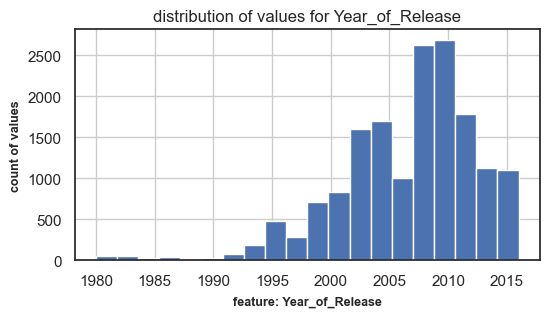

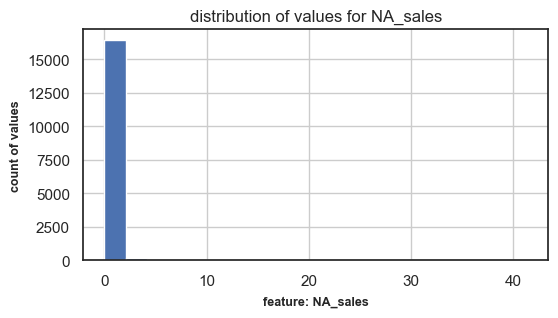

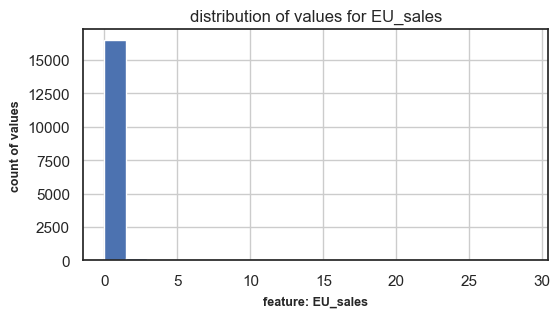

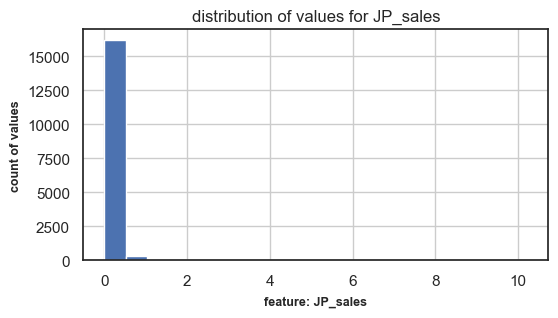

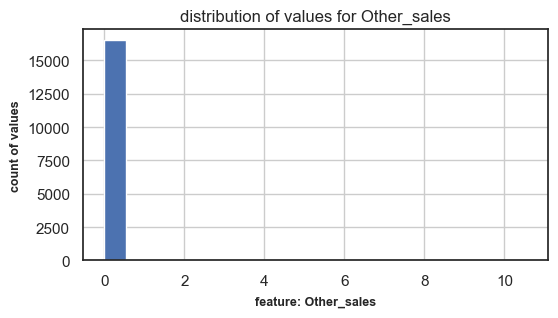

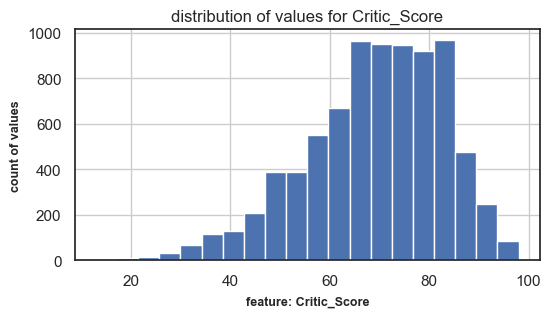

In [40]:
columns = data.columns.tolist()

for column in columns:
    if data.dtypes[column] == object:
        pass
    else:
        data[column].hist(bins=20, figsize=(6, 3))
        plt.title(f'distribution of values for {column}')
        plt.xlabel(f'feature: {column}', 
                   fontsize=9, fontweight='bold', labelpad=6)
        plt.ylabel('count of values', fontsize=9, fontweight='bold')
        plt.show()

The overall data distribution looks as expected: a relatively small number of games before 1995, followed by growth, after which there is a decline and market stabilization. Based on the sales graphs in various regions, we can observe the presence of outliers. Critic ratings are close to a normal distribution, while user ratings do not follow a normal distribution, which is expected since the column is of object type. In the next steps of the study, we will clean the data and analyze the distribution of these features.

The dataset contains 1675 observations with 11 features that will help us explore the market. Based on the general information about the dataset, we will define the data preprocessing plan:
* Correct column names
* Convert data types for the year of release
* Investigate missing values in each column
* Check the dataset for duplicates
* Add information about total sales for each game

## 2. Data Preprocessing
### 2.1. Table Header and Data Types

In [41]:
data.columns = map(str.lower, data.columns)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [42]:
data = data.astype({"year_of_release": "Int64"})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.4+ MB


In the `user_score` column, the data type is object, which likely means there are strings in addition to numbers. Let's take a look at the unique values in the column:

In [43]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Among the numerical values, `"tbd"` has appeared. For now, we will leave it unchanged. Later, during the missing data handling stage, we will decide whether to remove it or replace it with a numerical value. After removing the string data, we will change the type from `object` to `float64`.
### 2.2 Handling Duplicates
Let's check the dataset for duplicates based on key parameters: name, platform, and year of release. If duplicates are found with discrepancies in sales, it makes sense to merge the records by summing the sales.

In [44]:
print(data[data.duplicated(['name', 'platform', 'year_of_release'])].count())
           
data[data.duplicated(['name', 'platform', 'year_of_release'], keep=False)].sort_values('name')

name               1
platform           2
year_of_release    2
genre              1
na_sales           2
eu_sales           2
jp_sales           2
other_sales        2
critic_score       1
user_score         1
rating             1
dtype: int64


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


There are two records about games that duplicate key characteristics. One of the records is for a game without a name, genre, ratings, and with almost no sales. We will remove both records. We will return to the remaining duplicate with index 14244 during the handling of missing values.

In [45]:
data.at[604, 'eu_sales'] = 0.23
data = data.drop_duplicates(['name', 'platform', 'year_of_release'])


print(f"{data.info()} \n \n"
      f"Number of duplicates:\n{data[data.duplicated(['name', 'platform', 'year_of_release'])].count()}"
     )

<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16712 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  object 
 10  rating           9948 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.5+ MB
None 
 
Number of duplicates:
name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score       

### 2.3 Handling Missing Values
Before we start working with missing values, let's assess the proportion of missing data in each column and record it in a separate table:

In [46]:
missing_data_start = data.isna().sum().to_frame().rename(columns = {0: 'missing_values_start'})

missing_data_start['total_values_start'] = data.shape[0]
missing_data_start['% of total_start'] = (missing_data_start['missing_values_start'] / data.shape[0] * 100).round(2)

missing_data_start.sort_values('missing_values_start', ascending = False)

,missing_values_start,total_values_start,% of total_start
critic_score,8577,16713,51.32
rating,6765,16713,40.48
user_score,6700,16713,40.09
year_of_release,269,16713,1.61
name,1,16713,0.01
genre,1,16713,0.01
platform,0,16713,0.00
na_sales,0,16713,0.00
eu_sales,0,16713,0.00
jp_sales,0,16713,0.00


#### 2.3.1 NAME & GENRE
The columns `name` and `genre` have the least amount of missing data: 0.01% of the total observations, which is one record left over from the duplicate cleanup. Let's take a look at this record before deleting it:

In [47]:
data.query('name.isna() or genre.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.0,0.08,NaN,NaN,NaN


This row has missing values in key parameters essential for our analysis. Let's delete it from the main dataset:

In [48]:
data = data.query('name.notna()')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16712 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16712 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16712 non-null  object 
 4   na_sales         16712 non-null  float64
 5   eu_sales         16712 non-null  float64
 6   jp_sales         16712 non-null  float64
 7   other_sales      16712 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  object 
 10  rating           9948 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.5+ MB


#### 2.3.2 YEAR_OF_RELEASE
We also see a larger, but still non-critical, number of missing values (1.61%) in the `year_of_release` column. To begin with, let's check if we can restore the release year using the release date of the game on other consoles. We will create a pivot table, counting the number of different release years for each unique value in the "name" column.

In [49]:
releases = (data.pivot_table(index='name', 
                    values='year_of_release', 
                    aggfunc=pd.Series.nunique)
            .sort_values('year_of_release', ascending=False)
            .rename(columns = {'year_of_release': 'years_count'})
            .reset_index()
           )

print(f"Distribution of games by release date across different platforms: \n"
      f"{releases['years_count'].value_counts()}"
     )
releases

Distribution of games by release date across different platforms: 
years_count
1    10732
2      633
0      133
3       49
4       10
5        2
Name: count, dtype: Int64


,name,years_count
0,SimCity 2000,5
1,Monopoly,5
2,Jeopardy!,4
3,Warriors Orochi 3,4
4,NBA Jam,4
...,...,...
11554,Swords,0
11555,Charm Girls Club: My Fashion Mall,0
11556,Charm Girls Club: My Fashion Show,0
11557,Sword of the Samurai,0


The proportion of games with different release years across platforms is not large, but there is still some variability. Since we currently cannot clarify the release date for each problematic observation, it is best to remove these rows. Losing 1.61% of the sample will not affect its representativeness.

In [50]:
data = data.query('year_of_release.notna()')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       9838 non-null   object 
 10  rating           9767 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.5+ MB


#### 2.3.3 RATING
`rating		40.48%`  
The dataset has 40% of observations with missing ratings. It is not advisable to fill in the blanks with the most frequent values within each genre for each platform, as we do not have game characteristics, nor do we know the criteria used for the ratings. Therefore, we will replace the missing values with `unknown`:

In [51]:
data['rating'] = data['rating'].fillna('unknown')
data['rating'].value_counts()

rating
unknown    6676
E          3920
T          2905
M          1536
E10+       1393
EC            8
K-A           3
AO            1
RP            1
Name: count, dtype: int64

#### 2.3.4 CRITIC_SCORE
`critic_score	51.32%`  
This column has the most significant number of missing values, and replacing them with the median or mean is not advisable. Before deciding what to do with this column, let's examine the data on games without ratings: for each year, we will count the number of games without ratings, the total number of games, and calculate the proportion of games without ratings relative to the total number of games.

In [52]:
no_critic = (data.query('critic_score.isna()')
             .pivot_table(index='year_of_release',
                          values='name',             
                          aggfunc='count',
                          fill_value=0
                         )
             .rename(columns = {'name': 'quantity'})
             )

games_by_year = (data.pivot_table(index='year_of_release',
                                  values='name', 
                                  aggfunc='count',
                                  fill_value=0
                                  )
             .rename(columns = {'name': 'total_quantity'})
             )

no_critic_compare = no_critic.join(games_by_year, how='outer')
no_critic_compare['%_of_total'] = (no_critic_compare['quantity'] 
                                   / no_critic_compare['total_quantity'] * 100).round(2)
no_critic_compare

,quantity,total_quantity,%_of_total
year_of_release,,,
1980,9,9,100.00
1981,46,46,100.00
1982,36,36,100.00
1983,17,17,100.00
1984,14,14,100.00
1985,13,14,92.86
1986,21,21,100.00
1987,16,16,100.00
1988,14,15,93.33


The significant number of missing values is primarily explained by the fact that there was likely no practice of rating games before 1996. Starting from 1996, we see an increase in the number of games that received ratings from critics. From 2000 onward, we can say that the game rating process became well-established. Despite this, the number of missing values remains substantial, likely because not every game attracts the attention of critics.

We will replace the missing values with a value that will clearly differ from actual user ratings:

In [53]:
data['critic_score'] = data['critic_score'].fillna(-1)

print(f"Missing values in critic_score: {data['critic_score'].isna().sum()}")

Missing values in critic_score: 0


#### 2.3.5 USER_SCORE 
`user_score	    40.09%`  
Just like with critic scores, let's first take a look at how user attention has changed over time. We will create a table that consolidates information on the number of reviews, number of games, and the share of games with reviews year by year:

In [54]:
no_user = (data.query('user_score.isna()')
             .pivot_table(index='year_of_release',
                          values='name', 
                          aggfunc='count',
                          fill_value=0
                         )
             .rename(columns = {'name': 'quantity'})
             )

no_user_compare = no_user.join(games_by_year, how='outer')
no_user_compare['%_of_total'] = (no_user_compare['quantity'] 
                                   / no_user_compare['total_quantity'] * 100).round(2)
no_user_compare

,quantity,total_quantity,%_of_total
year_of_release,,,
1980,9,9,100.00
1981,46,46,100.00
1982,36,36,100.00
1983,17,17,100.00
1984,14,14,100.00
1985,13,14,92.86
1986,21,21,100.00
1987,16,16,100.00
1988,14,15,93.33


User behavior mirrors that of critics: starting from 1996, the number of ratings gradually increases, and by 2000, the process stabilizes. As with critic scores, we will replace the missing values with a unique value that will differ from the actual ratings:

In [55]:
data['user_score'] = data['user_score'].fillna(-1)

print(f"Missing values in user_score: {data['critic_score'].isna().sum()}")

Missing values in user_score: 0


Among the user ratings, there is a string value `"tbd"` (to be defined), meaning that at the time of the data extraction, the collection of user ratings was not yet complete. For the purposes of our project, this value can be treated as a missing value, as we cannot associate it with other numerical values.

In [56]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = -1
data['user_score'] = data['user_score'].astype('float64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  float64
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


Before drawing an interim conclusion, let's assess the losses in the dataset: we will compare the metrics at the start and at the end of the data preprocessing process.

In [57]:
missing_data_final = data.isna().sum().to_frame().rename(columns = {0: 'missing_values_final'})

missing_data_final['total_values_final'] = data.shape[0]
missing_data_final['% of total_final'] = (missing_data_final['missing_values_final'] / data.shape[0] * 100).round(2)


missing_data_final = missing_data_start.join(missing_data_final)

missing_data_final['% data_loss'] = (((missing_data_final['total_values_start']
                                       - missing_data_final['total_values_final'])
                                      / missing_data_final['total_values_start'] * 100)
                                     .round(2)
                                    )
                                    
missing_data_final

,missing_values_start,total_values_start,% of total_start,missing_values_final,total_values_final,% of total_final,% data_loss
name,1,16713,0.01,0,16443,0.0,1.62
platform,0,16713,0.00,0,16443,0.0,1.62
year_of_release,269,16713,1.61,0,16443,0.0,1.62
genre,1,16713,0.01,0,16443,0.0,1.62
na_sales,0,16713,0.00,0,16443,0.0,1.62
eu_sales,0,16713,0.00,0,16443,0.0,1.62
jp_sales,0,16713,0.00,0,16443,0.0,1.62
other_sales,0,16713,0.00,0,16443,0.0,1.62
critic_score,8577,16713,51.32,0,16443,0.0,1.62
user_score,6700,16713,40.09,0,16443,0.0,1.62


**Summary**  
As a result of preparing the data for the research, we were able to fully eliminate missing values, with a data loss of just **1.62%**. Here's what we did during the preprocessing:

1. Standardized column names to the correct style
2. Identified and removed two duplicates
3. Removed games with no name or genre provided
4. Decided to delete 269 records with missing release year. Release date is a key parameter for our study, and filling in missing values with average values could significantly impact statistical analysis and hypothesis testing.
5. Filled 40% of missing values in the "rating" column with the value "unknown". As with the release year, we concluded that artificially filling missing values with the most frequent ones would negatively affect the data quality.
6. We found that until 1996, neither users nor critics consistently rated games, and that the rating process became stable around 2000. The missing values in this case can be attributed to both errors in data collection and parsing, as well as the fact that the number of games on the market significantly exceeds the number of people willing to rate them. Not all games attract the attention of users or critics. In both cases, we replaced missing values with -1 — a numerical value that clearly differs from real ratings.

### 2.4 Total sales calculation
For further analysis, we need information about how many copies of each game were sold worldwide. The data has already been cleaned, so now we will add the final touch:

In [58]:
data['total_sales'] = data.loc[:,['na_sales','eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
data.sort_values('total_sales', ascending=False).head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,unknown,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,-1.0,-1.0,unknown,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,-1.0,-1.0,unknown,28.31


The dataset is now fully prepared for exploratory data analysis.

## 3. Exploratory Data Analysis
To understand the characteristics of the video game market, we will explore the dataset in terms of the following key features:
* Dynamics of game releases year by year
* Popularity of gaming platforms year by year
* Identification of the current period for sales
* Identification of sales leaders among platforms
* Identification of platforms losing popularity
* Analyzing the relationship between sales and ratings by critics and users
* Identification of the most profitable game genres

### 3.1 Dynamics of Game Releases Year by Year
We will prepare a pivot table where the rows will represent the years of game releases and the columns will show the total number of copies sold across all platforms.

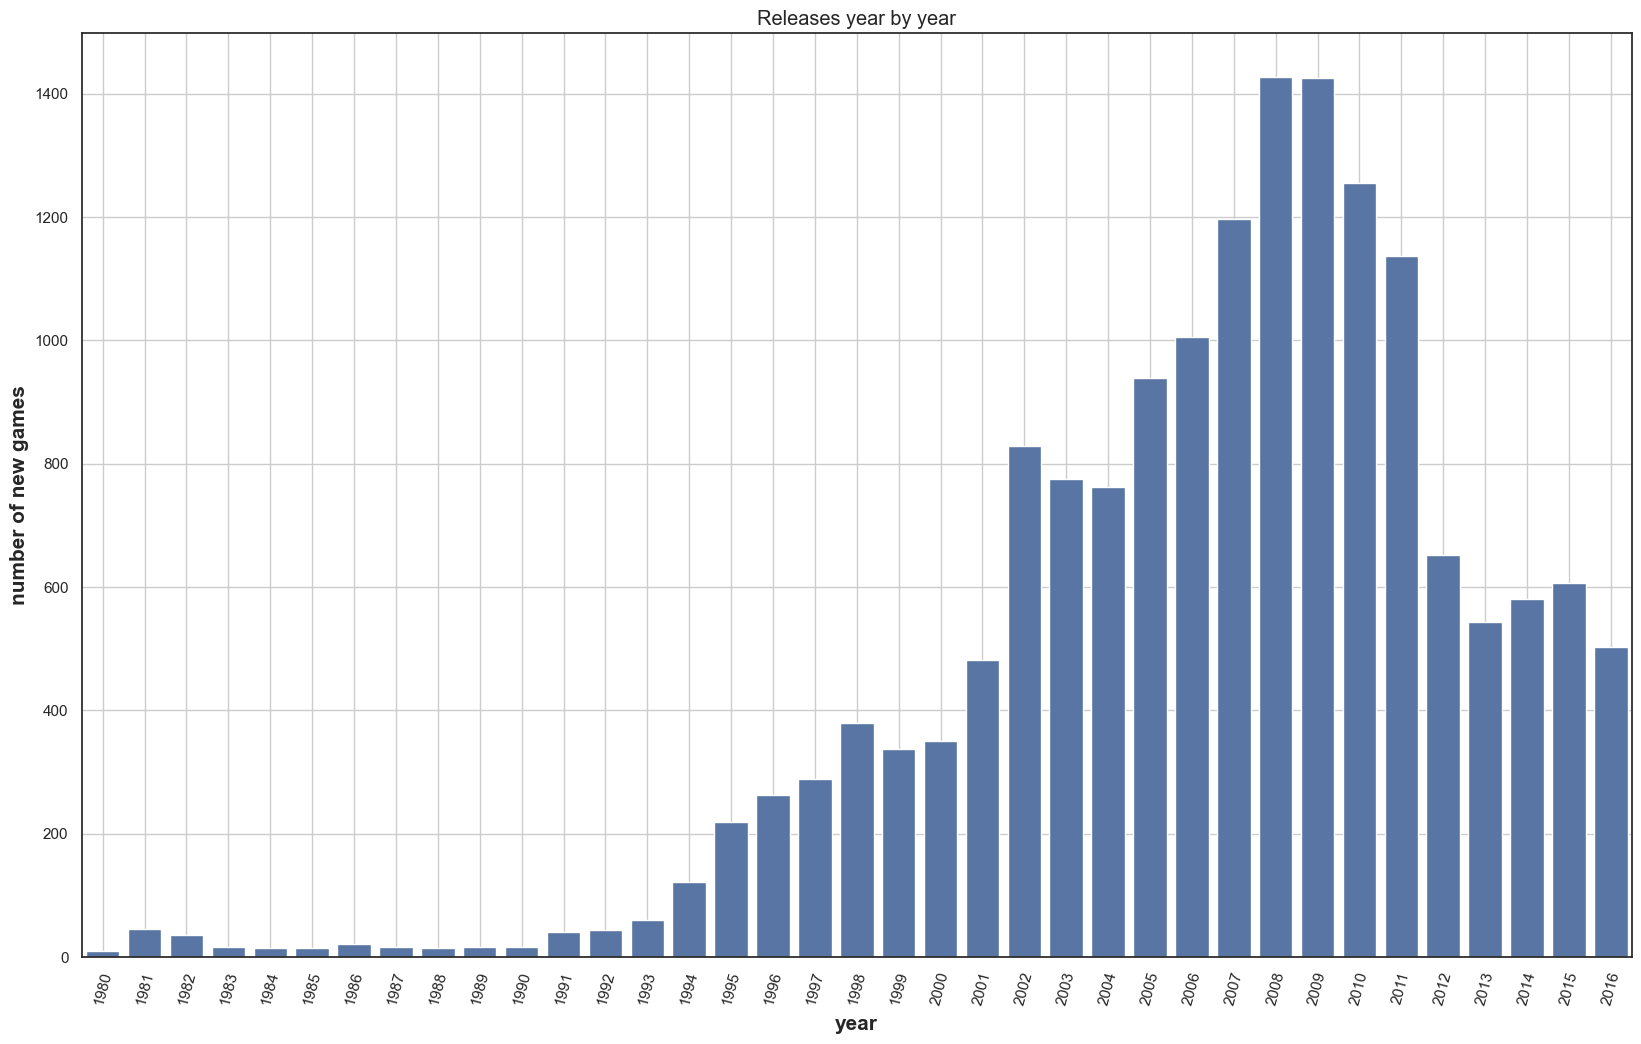

In [59]:
quantity = (data.pivot_table(index='year_of_release', values='total_sales', aggfunc='count')
            .rename(columns = {'total_sales': 'quantity'})
            .reset_index()
           )
 

sns.barplot(data=quantity, x='year_of_release', y='quantity')
sns.set_theme(rc={'figure.figsize': (17, 9)}, style='white')
sns.set(font_scale=1.2)
plt.title('Releases year by year')
plt.xlabel('year', fontsize=15, fontweight='bold', labelpad=6)
plt.ylabel('number of new games', fontsize=15, fontweight='bold')
plt.xticks(rotation=75)
plt.grid(True)
plt.show()

The graph shows the emergence of new games in the market from 1980 to 2016. Starting in 1994, there is a noticeable increase in the number of releases, which peaks in 2008-2009, followed by a decline. From 2012 to 2016, the market stabilizes without sharp peaks or drops. This period seems the most favorable for further research for several reasons:
* Relative market stability
* Releases of new gaming platforms (we need more up-to-date data on consoles for predictions, as new games are being developed for them)
* New games attract more interest from users, while older games, released 5 years ago or more, are much less frequently revisited, especially when it comes to attracting new users.
### 3.2 Dynamics of Platform Profitability Year by Year
Let's take a look at how total sales by platform have changed year by year. The dataset spans over 30 years, during which many gaming consoles have risen and faded in popularity.

First, we will visualize the sales across platforms to identify the most popular consoles.

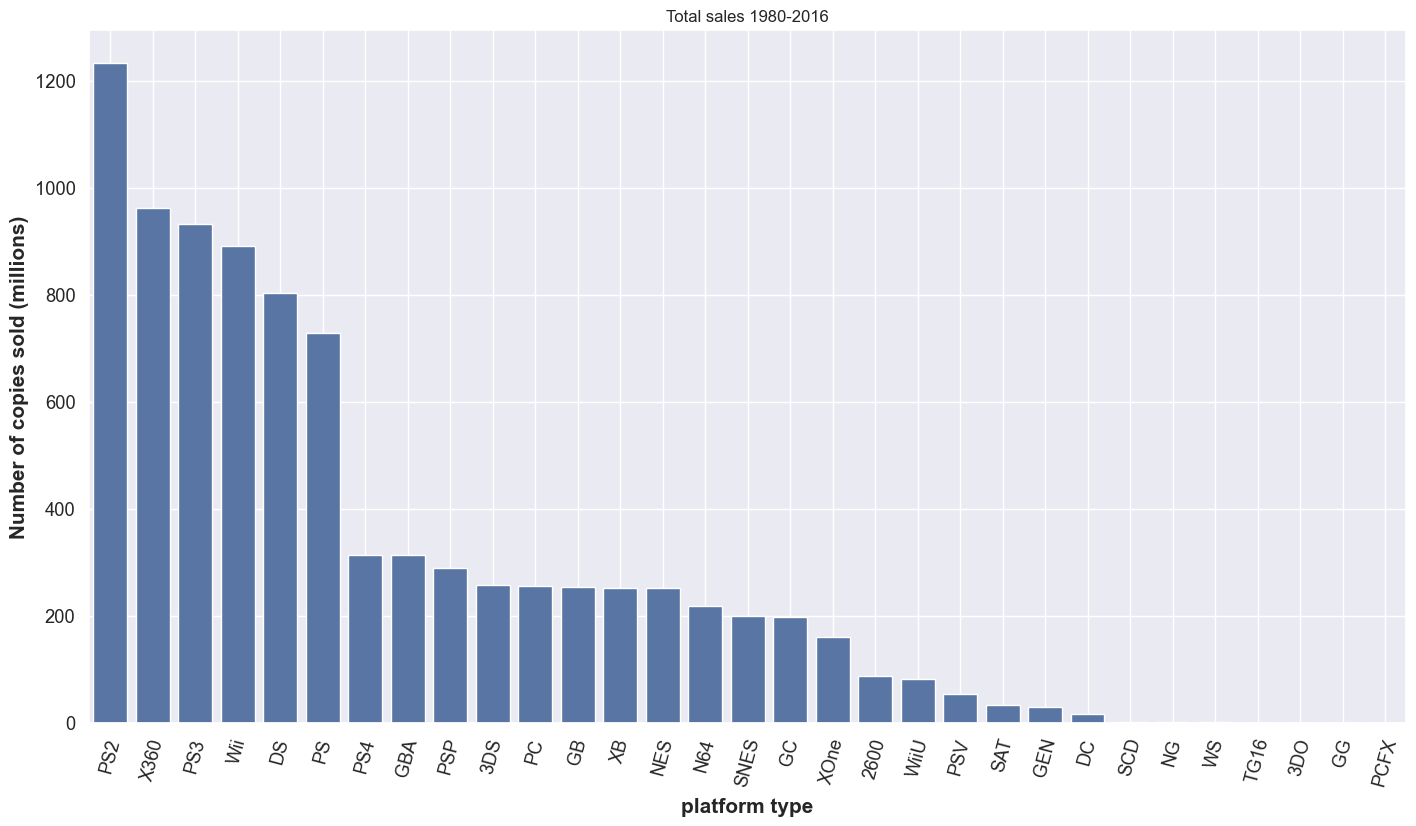

In [60]:
platform_sales = (data.pivot_table(index='platform',
                                  values='total_sales',
                                  aggfunc='sum',
                                  fill_value=0)
                  .reset_index()
                  .sort_values('total_sales', ascending=False)
                 )
sns.barplot(data=platform_sales, x='platform', y='total_sales')
sns.set(font_scale=1.2)
sns.set_theme(rc={'figure.figsize':(20, 12)}, style='white')
plt.title('Total sales 1980-2016')
plt.xlabel('platform type', fontsize=15, fontweight='bold', labelpad=6)
plt.ylabel('Number of copies sold (millions)', fontsize=15, fontweight='bold')
plt.xticks(rotation=75)
plt.grid(True)
plt.show()

The chart clearly shows the top 6 platforms with the best sales over the entire historical period. However, these are data for the entire period. Let's now look at how sales are distributed by year for `PS2`, `X360`, `PS3`, `Wii`, `DS`, and `PS`.

In [61]:
top = (data.query("platform == ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']")
           .pivot_table(values=['total_sales'],
                        index=['year_of_release'],
                        columns=['platform'],
                        aggfunc='sum', 
                     fill_value=0)
          )
top

total_sales                                        
platform                 DS      PS     PS2     PS3     Wii    X360
year_of_release                                                    
1985                   0.02    0.00    0.00    0.00    0.00    0.00
1994                   0.00    6.03    0.00    0.00    0.00    0.00
1995                   0.00   35.96    0.00    0.00    0.00    0.00
1996                   0.00   94.70    0.00    0.00    0.00    0.00
1997                   0.00  136.17    0.00    0.00    0.00    0.00
1998                   0.00  169.49    0.00    0.00    0.00    0.00
1999                   0.00  144.53    0.00    0.00    0.00    0.00
2000                   0.00   96.37   39.17    0.00    0.00    0.00
2001                   0.00   35.59  166.43    0.00    0.00    0.00
2002                   0.00    6.67  205.38    0.00    0.00    0.00
2003                   0.00    2.07  184.31    0.00    0.00    0.00
2004                  17.27    0.00  211.81    0.00    0.00    0.00
2005                 130.14    0.00  160.66    0.00    0.00    8.25
2006                 119.81    0.00  103.42   20.96  137.15   51.62
2007                 146.94    0.00   75.99   73.19  152.77   95.41
2008                 145.31    0.00   53.90  118.52  171.32  135.26
2009                 119.54    0.00   26.40  130.93  206.97  120.29
2010                  85.02    0.00    5.64  142.17  127.95  170.03
2011                  26.18    0.00    0.45  156.78   59.65  143.84
2012                  11.01    0.00    0.00  107.36   21.71   99.74
2013                   1.54    0.00    0.00  113.25    8.59   88.58
2014                   0.00    0.00    0.00   47.76    3.75   34.74
2015                   0.00    0.00    0.00   16.82    1.14   11.96
2016                   0.00    0.00    0.00    3.60    0.18    1.52

In the pivot table, two points draw attention:

1. The sales for the DS platform in 1985 are likely erroneous: it is known that the Nintendo DS console was released in 2004.
2. The popular platform PS does not appear in our relevant period from 2012-2016. We will keep it in the table for a better understanding of the lifespan of platforms, but we will also add the most recent platforms. Their overall sales will be lower than those of the veterans, but they will be important for forecasting the upcoming period.

First, let's check the outlier for the DS console.

In [62]:
data.query("platform == 'DS' and year_of_release == 1985")

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,-1.0,-1.0,unknown,0.02


The data for this game in external sources is sparse and inconsistent: some sources indicate that the game was released in 1985, while others mention 2007 or 2010. Given that most of the data for this observation is missing, we will remove this outlier.

In [63]:
data = data.drop(index=15957)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16442 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16442 non-null  object 
 1   platform         16442 non-null  object 
 2   year_of_release  16442 non-null  Int64  
 3   genre            16442 non-null  object 
 4   na_sales         16442 non-null  float64
 5   eu_sales         16442 non-null  float64
 6   jp_sales         16442 non-null  float64
 7   other_sales      16442 non-null  float64
 8   critic_score     16442 non-null  float64
 9   user_score       16442 non-null  float64
 10  rating           16442 non-null  object 
 11  total_sales      16442 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.6+ MB


In [64]:
data.query("year_of_release == 2016")['platform'].unique()

array(['PS4', '3DS', 'XOne', 'WiiU', 'PS3', 'PC', 'X360', 'PSV', 'Wii'],
      dtype=object)

Let's compare them with our original list and display the elements that need to be added.

In [65]:
set_1 = data.query("year_of_release == 2016")['platform'].unique()
set_2 = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

set_3 = []
for i in set_1:
    if i not in set_2:
        set_3.append(i)
print(set_3)

['PS4', '3DS', 'XOne', 'WiiU', 'PC', 'PSV']


In [66]:
top = (data.query("platform == ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', '3DS', 'XOne', 'WiiU', 'PC', 'PSV']")
           .pivot_table(values=['total_sales'],
                        index=['year_of_release'],
                        columns=['platform'],
                        aggfunc='sum', 
                        fill_value=0)
          )
top.head(10)

total_sales                                                 \
platform                3DS   DS     PC      PS    PS2  PS3  PS4  PSV  Wii   
year_of_release                                                              
1985                    0.0  0.0   0.04    0.00   0.00  0.0  0.0  0.0  0.0   
1988                    0.0  0.0   0.03    0.00   0.00  0.0  0.0  0.0  0.0   
1992                    0.0  0.0   3.03    0.00   0.00  0.0  0.0  0.0  0.0   
1994                    0.0  0.0  12.87    6.03   0.00  0.0  0.0  0.0  0.0   
1995                    0.0  0.0   4.22   35.96   0.00  0.0  0.0  0.0  0.0   
1996                    0.0  0.0  10.58   94.70   0.00  0.0  0.0  0.0  0.0   
1997                    0.0  0.0  11.27  136.17   0.00  0.0  0.0  0.0  0.0   
1998                    0.0  0.0   3.26  169.49   0.00  0.0  0.0  0.0  0.0   
1999                    0.0  0.0   4.74  144.53   0.00  0.0  0.0  0.0  0.0   
2000                    0.0  0.0   4.66   96.37  39.17  0.0  0.0  0.0  0.0   

                                
platform        WiiU X360 XOne  
year_of_release                 
1985             0.0  0.0  0.0  
1988             0.0  0.0  0.0  
1992             0.0  0.0  0.0  
1994             0.0  0.0  0.0  
1995             0.0  0.0  0.0  
1996             0.0  0.0  0.0  
1997             0.0  0.0  0.0  
1998             0.0  0.0  0.0  
1999             0.0  0.0  0.0  
2000             0.0  0.0  0.0

Еverything is correct, we can visualize the sales distribution. For better clarity, let's use a heatmap

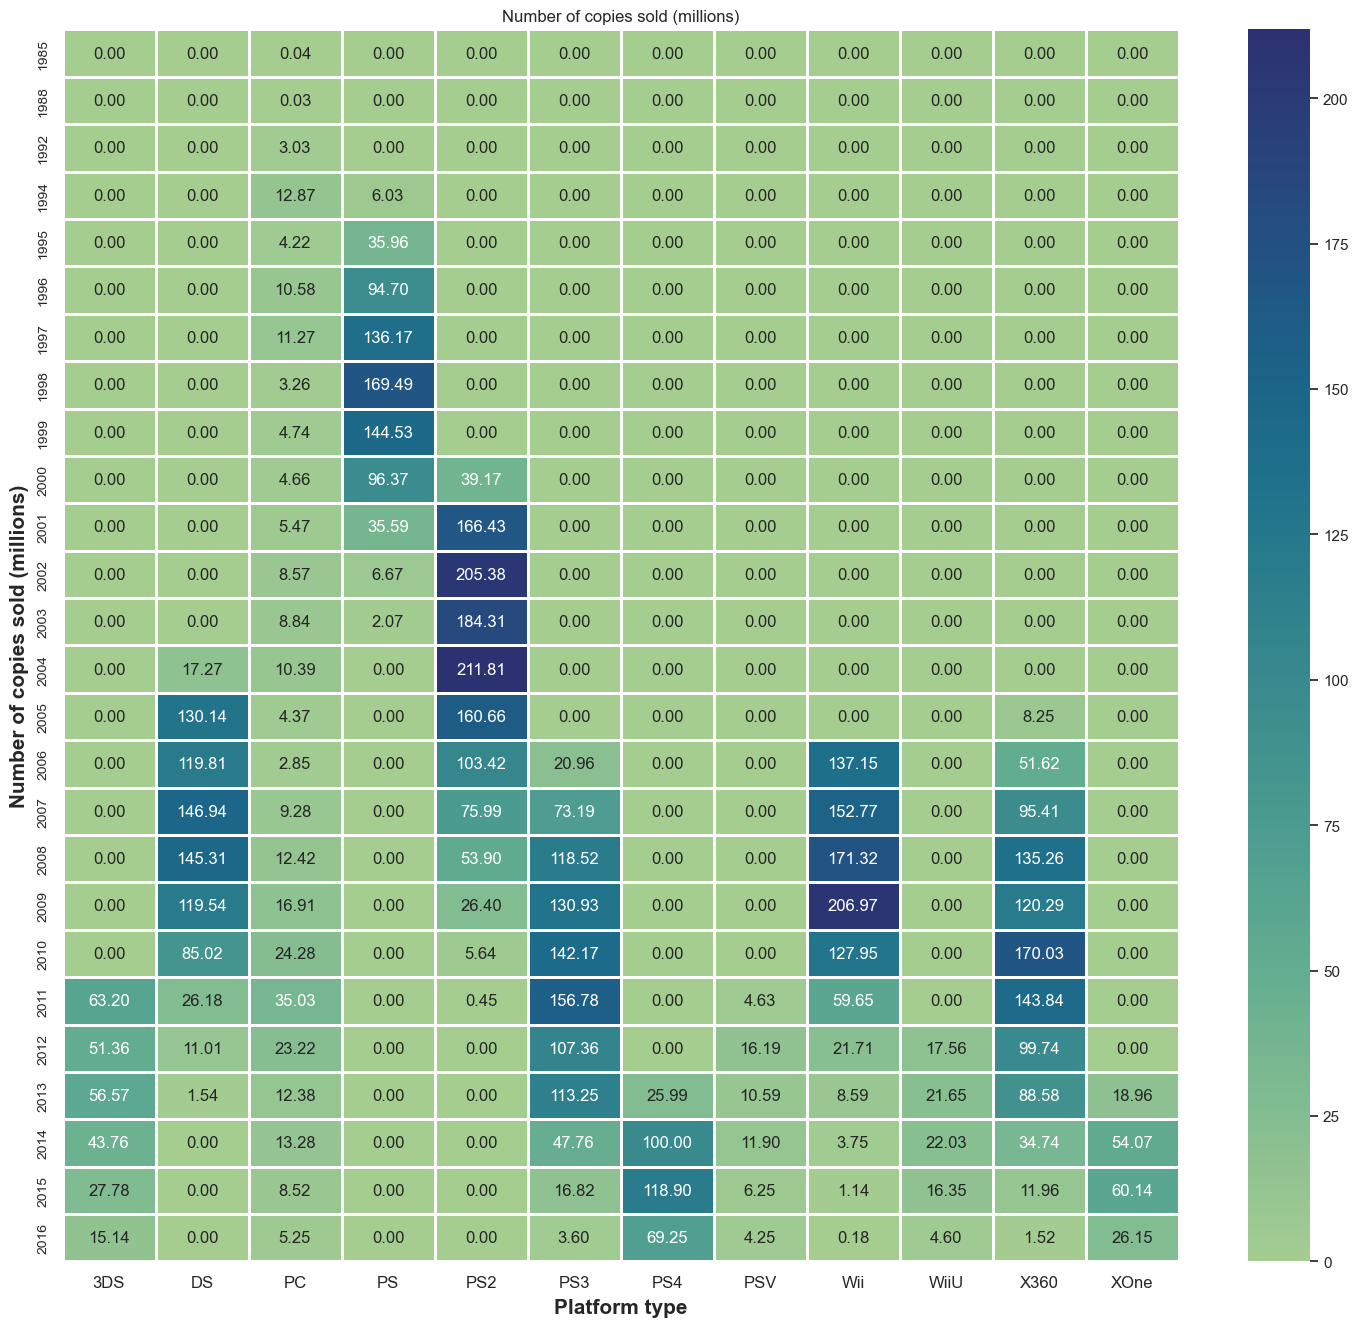

In [67]:
plt.figure(figsize=(18,16))
ax = sns.heatmap(top['total_sales'],linewidths=.8, annot=True, fmt='.2f', cmap="crest")
ax.set_yticklabels(ax.get_yticklabels(), va='center')
plt.title('Number of copies sold (millions)')
plt.xlabel('Platform type', fontsize=15, fontweight='bold', labelpad=6)
plt.xticks(size=12)
plt.ylabel('Number of copies sold (millions)', fontsize=15, fontweight='bold', labelpad=6)
plt.yticks(size=10)
plt.show()

Let's calculate the median lifespan of platforms in order to highlight the key platforms for sales forecasting in the next season:

In [68]:
time_life = data.pivot_table(index='platform', 
                             values='year_of_release', 
                             aggfunc=['min', 'max']).reset_index()

time_life
time_life['life'] = time_life['max'] - time_life['min'] + 1
                                                           
time_life['life'].median()

7.0

The median lifespan of a platform is 7 years. On our heatmap, the long-living `PC` stands out: 32 years in the gaming market, with overall sales not as high as consoles, but there are noticeable stable fluctuations: from smooth growth to gradual decline.

The addition of new platforms helped us identify the young `PS4` platform, which shows good sales.

It’s interesting to note that some consoles have a sharp start (`Wii` — 137.15 million copies in the year of the platform’s release), but it typically takes 2-3 years to gain momentum. In almost all cases, the last three years of a platform's life are the least productive. This should be taken into account when planning marketing campaigns.

The `PS4` console experiences a sharp decline in its fourth year, when sales should theoretically be at their peak. This may be related to the fact that the dataset for 2016 is incomplete: this decline is observed across all platforms.

**Summary**  
Based on the distribution of the number of games released per year and the total number of games for each platform, the following conclusions can be made:

* The relevant period for research is from 2012 to 2016: this period of market stabilization is long enough to investigate the popularity dynamics of various game genres, but not too long, as it doesn’t cover outdated games.
* The gaming market is dominated by six platform brands worth focusing on: most games are developed specifically for these platforms.
* The average lifespan of a gaming platform is 7 years, and it takes 2-3 years to gain traction.
* For market research in the relevant period of 2012-2016, we will focus on sales from the following platforms: `3DS`, `PS3`, `PS4`, `X360`, `XOne`. Other platforms are either fading veterans or underperforming newcomers and are better set aside. The PC platform should be considered separately: its lifespan is significantly longer, and its sales dynamics differ from those of console platforms

### 3.3 Distribution of Sales
Let's investigate how global sales are distributed between 2012 and 2016.

In [69]:
fresh_data = data.query("year_of_release > 2011")
fresh_data.head(15)
fresh_data['year_of_release'].unique()

<IntegerArray>
[2013, 2015, 2012, 2014, 2016]
Length: 5, dtype: Int64

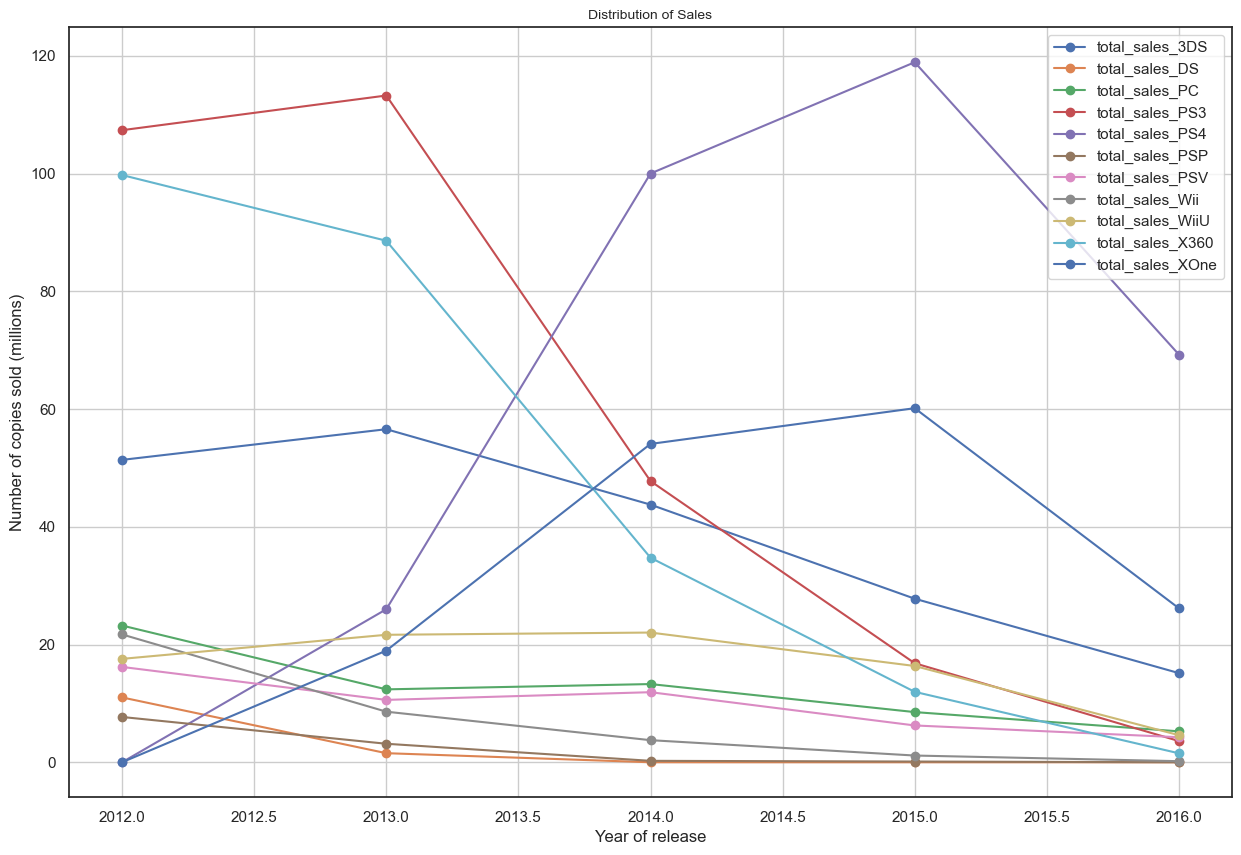

In [70]:
fresh_data_pivot = fresh_data.pivot_table(values=['total_sales'], 
                                          index=['year_of_release'],
                                          columns=['platform'], 
                                          aggfunc='sum', 
                                          fill_value=0)

fresh_data_pivot.columns = ['_'.join(str(s).strip() for s in col if s) for col in fresh_data_pivot.columns]


fresh_data_pivot.plot(style='o-', figsize=(15, 10))
plt.title(f'Distribution of Sales', fontsize=10)
plt.ylabel('Number of copies sold (millions)')
plt.xlabel('Year of release')
plt.grid(True)
plt.legend()
plt.show()

The graph displays the sales dynamics of platforms from 2012 to 2016.

* Observed growth: `PS4` and `XOne`
* Rapid decline: `PS3`, `X360`, `3DS`

Other platforms show a gradual decrease in sales. We do not take into account the decline in sales across all platforms in the 2015-2016 period, as it’s clear that sales data were not collected at the end of the reporting period, which negatively affected the dynamics of all observations.

Based on this, in terms of global sales, we can talk about the potential profitability of two consoles: PS4 and XOne.

For visualizing the distribution of global sales from 2012-2016, we will use a boxplot, which will help us evaluate and compare the most important statistics:

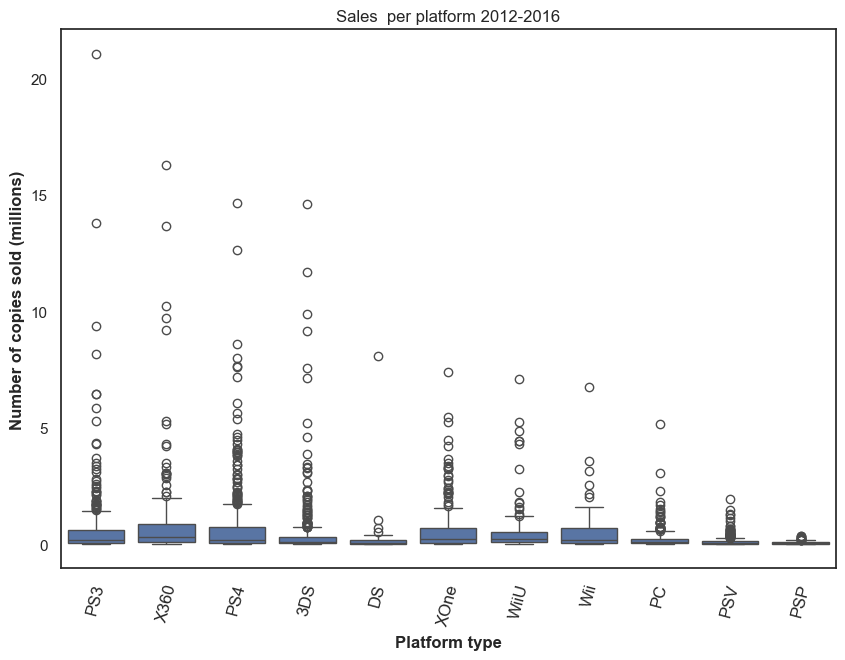

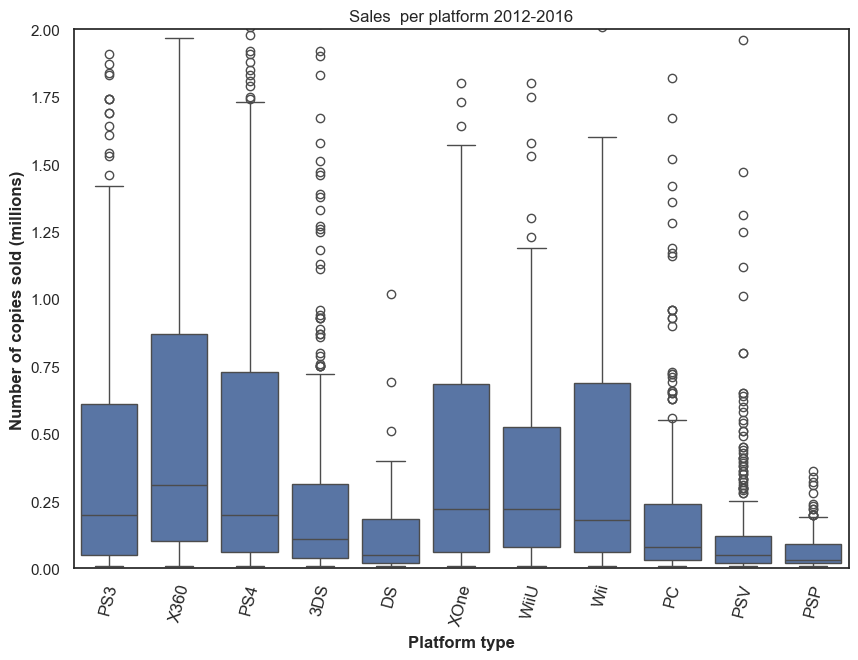

In [73]:
ax = sns.boxplot(data=fresh_data, x='platform', y='total_sales')
sns.set_theme(rc={'figure.figsize':(10, 7)}, style='white')
plt.title('Sales  per platform 2012-2016')
plt.xlabel('Platform type', fontsize=12, fontweight='bold', labelpad=6)
plt.ylabel('Number of copies sold (millions)', fontsize=12, fontweight='bold')
plt.xticks(size=12, rotation=75)
plt.show()


ax = sns.boxplot(data=fresh_data, x='platform', y='total_sales')
sns.set_theme(rc={'figure.figsize':(10, 7)}, style='white')
plt.title('Sales  per platform 2012-2016')
plt.xlabel('Platform type', fontsize=12, fontweight='bold', labelpad=6)
plt.ylim(0, 2)
plt.ylabel('Number of copies sold (millions)', fontsize=12, fontweight='bold')
plt.xticks(size=12, rotation=75)
plt.show()

The presented graphs show that the best sales figures (median value, upper threshold of outliers) are for the `X360` platform. However, if we refer to the graph we built earlier, the current period covers the final stage of the console’s life cycle, so we cannot forecast strong sales in 2017.

Among other platforms, the weakest performance is shown by the `3DS` platform: we initially saw this on the heatmap, and now it’s confirmed. The median sales for this console are twice as low as for the remaining three. Among the new platforms included in the general dataset slice for 2012-2016, we also see weak performance for the `PSV`, `PC`, and `PSP` platforms.

`PS3`, `PS4`, `XOne`, and `WiiU` have approximately the same median sales figures. However, like `3DS`, `PS3` shows a gradual decline in sales, which is expected since it was replaced by the new `PS4`. Currently, the most promising platforms seem to be `PS4` and `XOne`, as both platforms have entered the market relatively recently.

Additionally, by looking at the outlier tails present for each console, we can see that in all five cases, a few popular games account for most of the sales, with the number of copies sold being 7 to 20 times higher than the median value. Let’s see which games those are.

In [74]:
(fresh_data.pivot_table(index=['name','platform'],
                   values='total_sales',
                   aggfunc='sum')
             .reset_index()
             .sort_values('total_sales', ascending=False)
             .head(10)
 
)

,name,platform,total_sales
950,Grand Theft Auto V,PS3,21.05
952,Grand Theft Auto V,X360,16.27
320,Call of Duty: Black Ops 3,PS4,14.63
1820,Pokemon X/Pokemon Y,3DS,14.60
324,Call of Duty: Black Ops II,PS3,13.79
326,Call of Duty: Black Ops II,X360,13.68
951,Grand Theft Auto V,PS4,12.62
1816,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,11.68
331,Call of Duty: Ghosts,X360,10.24
1677,New Super Mario Bros. 2,3DS,9.90


The highest-grossing games turned out to be *Grand Theft Auto V* (for `PS3` and `X360`), *Call of Duty: Black Ops 3* (`PS4`), and *Pokemon X/Pokemon Y* (`3DS`). Games for the `XOne` platform didn’t make it into the top 10, but as we’ve already noted, this console doesn’t have blockbuster games.

Additionally, two points should be noted:

* Competing platform manufacturers have the same sales leaders: for example, *Grand Theft Auto V or Call of Duty: Black Ops II*.
* A game that becomes a hit on one platform may not achieve the same level of success on another platform.

**Summary** 
At this stage of the research, we have identified the characteristics of global game sales for five consoles: `3DS`, `PS3`, `PS4`, `X360`, and `XOne`. Among them, the most successful seems to be `X360`, but we cannot be sure whether sales will remain at the same level in the coming years. The most promising platforms are `PS4` and `XOne`. We also observed that the same games can generate significant sales for different consoles, but this statement depends on various commercial factors and requires further validation.

### 3.4 Influence of Ratings on Sales
At this stage of the research, we will examine how much user and critic ratings may influence sales. Let's start with user ratings.

We will build a scatter plot of user ratings for games for each of the selected five platforms.

Platform 3DS. Sales vs. User raiting corr:
0.2


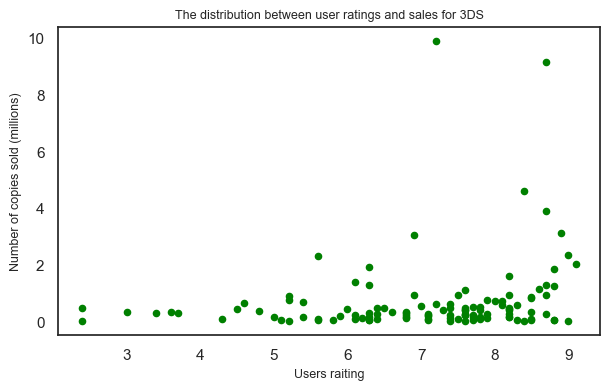

Platform PS3. Sales vs. User raiting corr:
-0.01


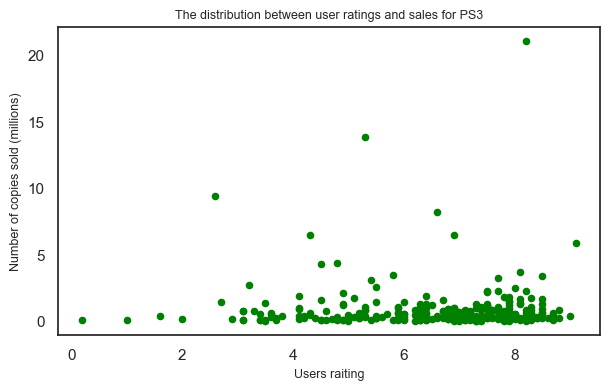

Platform PS4. Sales vs. User raiting corr:
-0.03


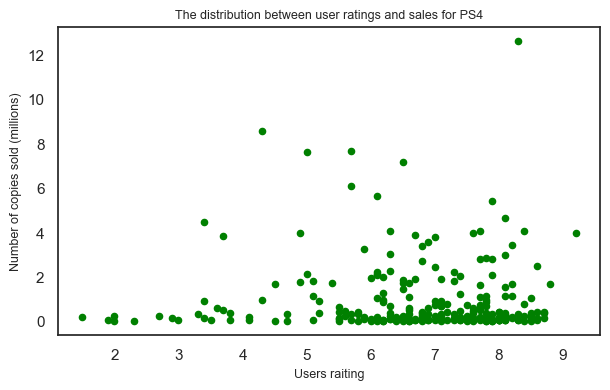

Platform X360. Sales vs. User raiting corr:
0.01


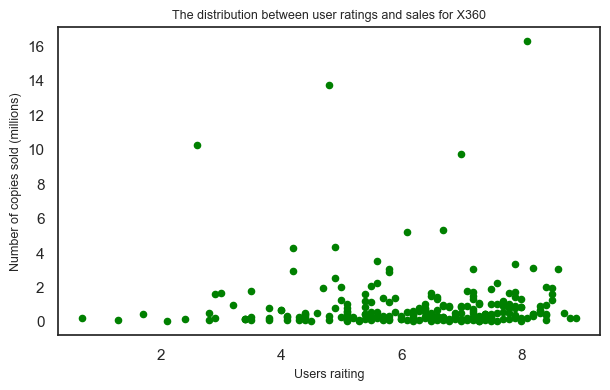

Platform XOne. Sales vs. User raiting corr:
-0.07


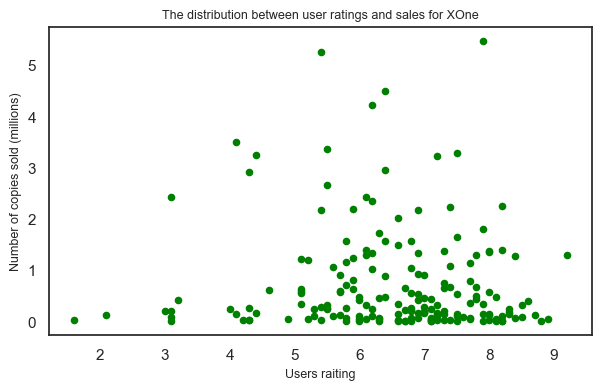

In [75]:
young_5 = ['3DS', 'PS3', 'PS4', 'X360', 'XOne']
young_5_data = data.query("platform in @young_5 and year_of_release > 2011")

for name in young_5:
    (young_5_data.query('platform == @name and user_score > -1')
     .plot(x='user_score', 
           y='total_sales',
           kind='scatter',
           figsize=(7, 4),
           color='green')
    )
    plt.title(f'The distribution between user ratings and sales for {name}', fontsize=9)
    plt.xlabel('Users raiting', fontsize=9)
    plt.ylabel('Number of copies sold (millions)', fontsize=9)
    print(f"Platform {name}. Sales vs. User raiting corr:")
    print(young_5_data.query('platform == @name and user_score > -1')['user_score']
          .corr(young_5_data.query('platform == @name and user_score > -1')['total_sales']).round(2))
    plt.show()

None of the selected platforms show a correlation between the number of copies sold and the rating given by users. We can assume that potential buyers might rely on other criteria when choosing a game. One of these could possibly be the critic's rating. Let's check.

Platform 3DS. Sales vs. Critic raiting corr:
0.32


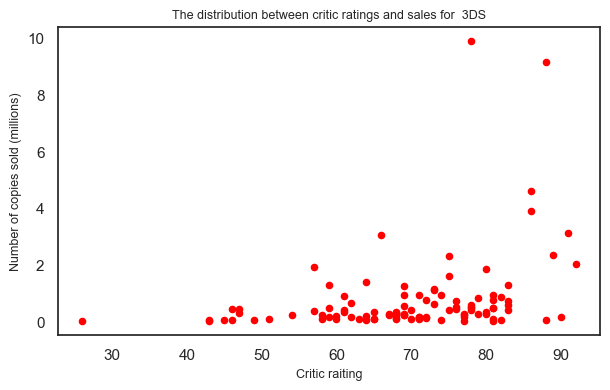

Platform PS3. Sales vs. Critic raiting corr:
0.33


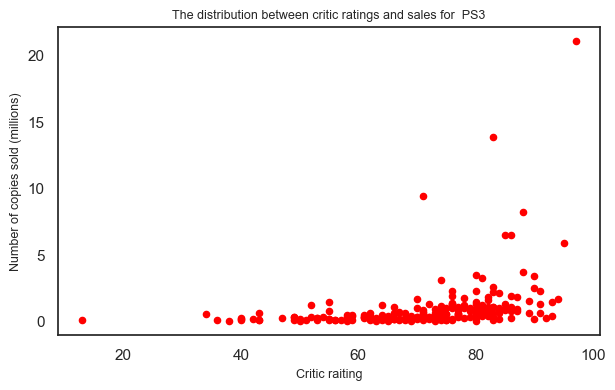

Platform PS4. Sales vs. Critic raiting corr:
0.41


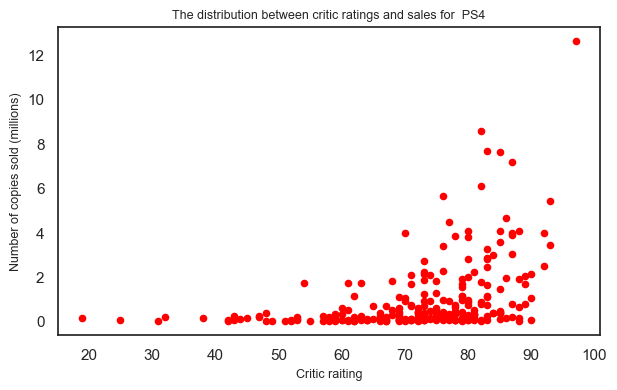

Platform X360. Sales vs. Critic raiting corr:
0.36


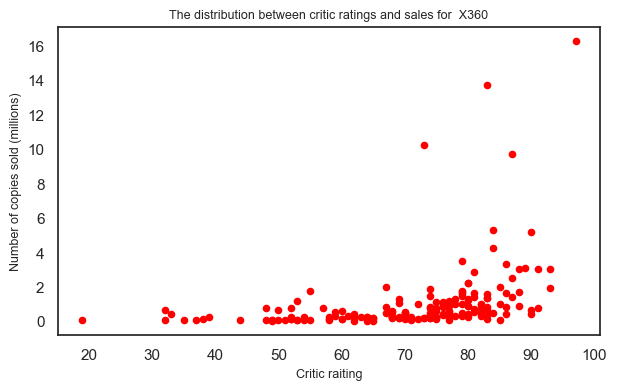

Platform XOne. Sales vs. Critic raiting corr:
0.42


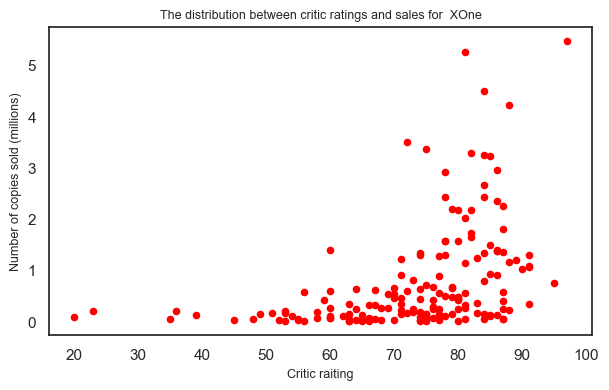

In [76]:
for name in young_5:
    (young_5_data.query('platform == @name and critic_score > -1')
     .plot(x='critic_score', 
           y='total_sales',
           kind='scatter',
           figsize=(7, 4),
           color='red')
    )
    plt.title(f'The distribution between critic ratings and sales for  {name}', fontsize=9)
    plt.xlabel('Critic raiting', fontsize=9)
    plt.ylabel('Number of copies sold (millions)', fontsize=9)
    print(f"Platform {name}. Sales vs. Critic raiting corr:")
    print(young_5_data.query('platform == @name and critic_score > -1')['critic_score']
          .corr(young_5_data.query('platform == @name and critic_score > -1')['total_sales']).round(2))
    plt.show()

There is a slight correlation between the rating and sales level, with the correlation being stronger for the `XOne` and `PS4` platforms compared to others. Most likely, the marketing campaigns promoting games on these platforms, among other promotional tools, use critic reviews, which users tend to trust.

### 3.5 Distribution of sales by genre
Now let's examine the sales distribution by game genre. First, we'll create a bar chart based on the pivot table, where each genre will have a total sales figure covering the period from 2012 to 2016.

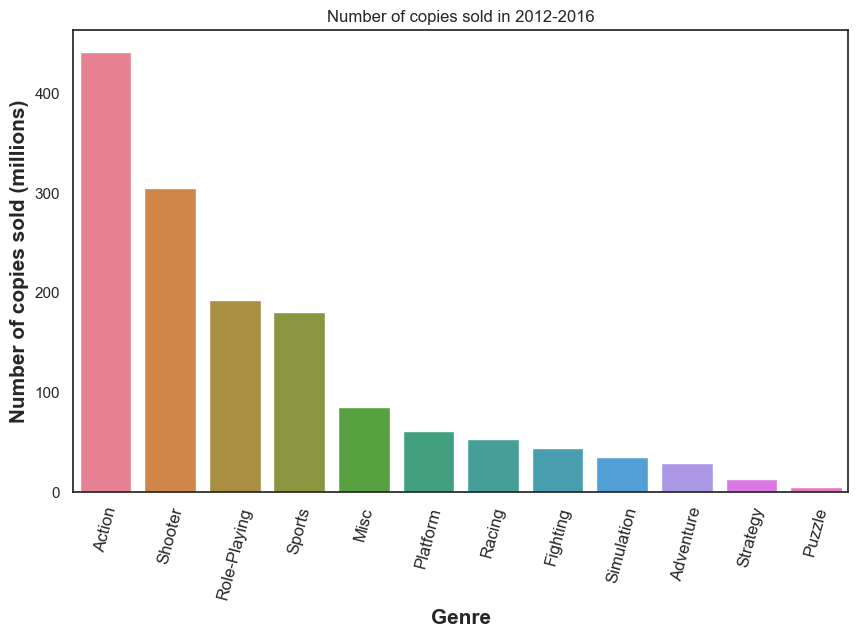

In [79]:
genre_sales = (fresh_data.pivot_table(index='genre',
                                  values='total_sales',
                                  aggfunc='sum',
                                  )
               .reset_index()
               .sort_values('total_sales', ascending=False)
                 )

sns.barplot(data=genre_sales, x='genre', y='total_sales', hue='genre')
sns.set(font_scale=1.2)
sns.set_theme(rc={'figure.figsize':(10, 6)}, style='white')
plt.title('Number of copies sold in 2012-2016')
plt.xlabel('Genre', fontsize=15, fontweight='bold', labelpad=6)
plt.ylabel('Number of copies sold (millions)', fontsize=15, fontweight='bold')
plt.xticks(size=12, rotation=75)
plt.show()

The top 4 best-selling genres, with a noticeable lead, are action, shooter, role-playing, and sports games. To better understand the specifics of each genre, let's look at the distribution of copies sold within each genre. For visualization, we will use a boxplot, which clearly shows the outliers.

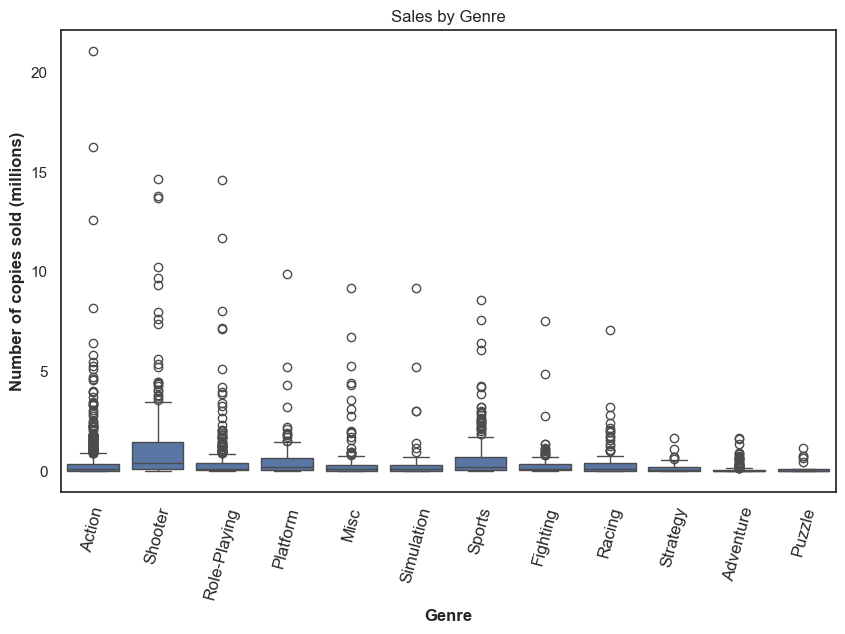

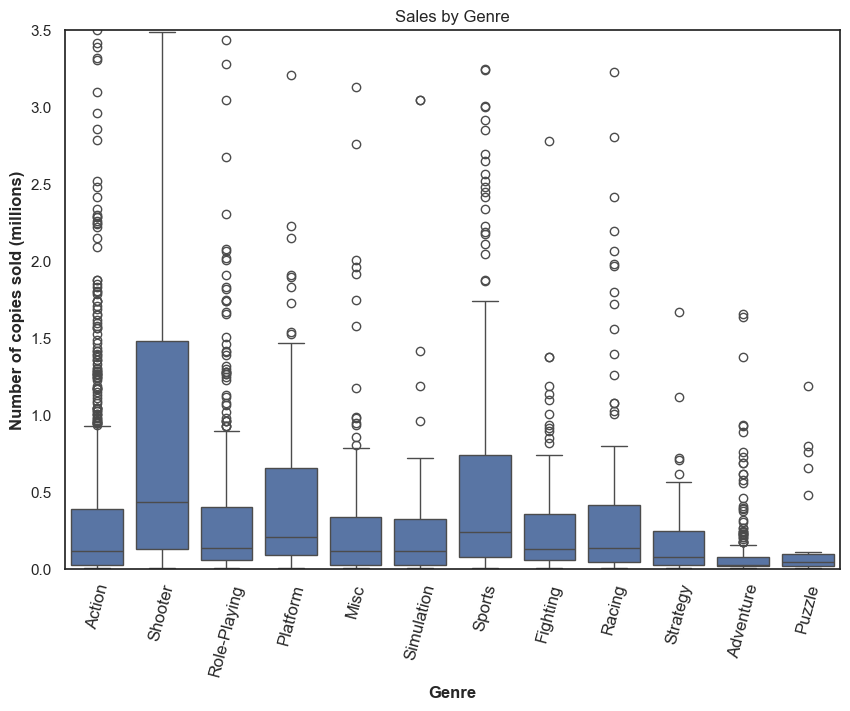

In [80]:
ax = sns.boxplot(data=fresh_data, x='genre', y='total_sales')
sns.set_theme(rc={'figure.figsize':(10, 7)}, style='white')
plt.title('Sales by Genre')
plt.xlabel('Genre', fontsize=12, fontweight='bold', labelpad=6)
plt.ylabel('Number of copies sold (millions)', fontsize=12, fontweight='bold')
plt.xticks(size=12, rotation=75)
plt.show()

ax = sns.boxplot(data=fresh_data, x='genre', y='total_sales')
sns.set_theme(rc={'figure.figsize':(10, 7)}, style='white')
plt.title('Sales by Genre')
plt.xlabel('Genre', fontsize=12, fontweight='bold', labelpad=6)
plt.ylabel('Number of copies sold (millions)', fontsize=12, fontweight='bold')
plt.xticks(size=12, rotation=75)
plt.ylim(0, 3.5)
plt.show()

In [81]:
(fresh_data.pivot_table(index='genre', 
                          values='total_sales',
                          aggfunc='median')
 .sort_values('total_sales', ascending=False))

,total_sales
genre,
Shooter,0.440
Sports,0.240
Platform,0.210
Role-Playing,0.140
Racing,0.140
Fighting,0.130
Action,0.120
Misc,0.120
Simulation,0.120


The sales of the action genre are driven by a few outliers, which have huge demand among users. Meanwhile, users who prefer shooters seem to be willing to play most games in this genre. The sales of sports and role-playing games are distributed similarly to the action genre.

Additionally, let's take a look at the dynamics of genre popularity within the relevant period from 2012 to 2016.

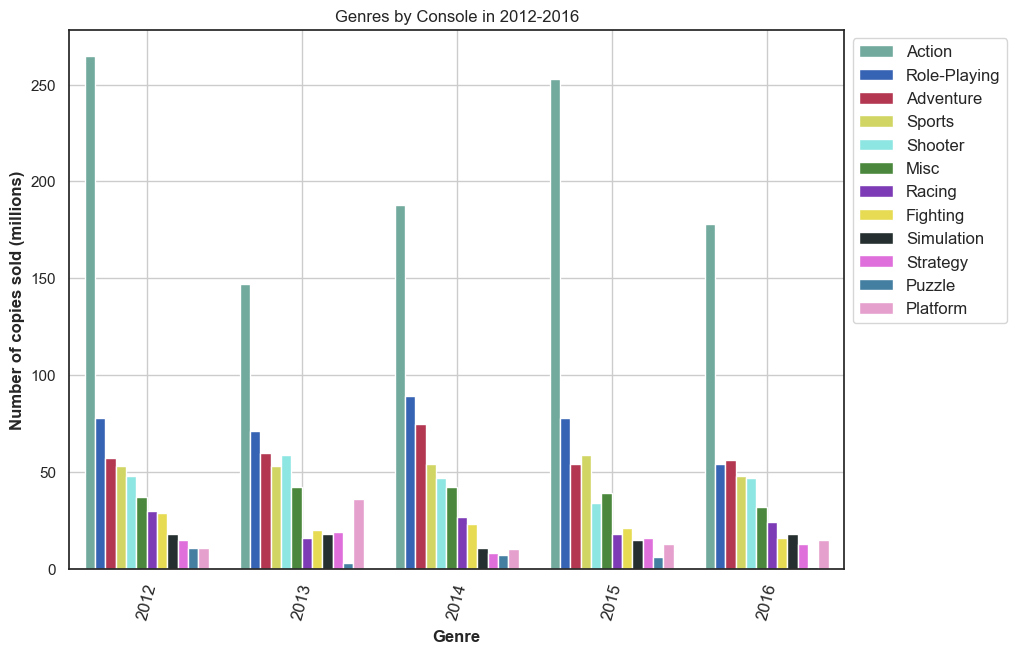

In [82]:
genre_dynamic = (fresh_data.pivot_table(index=['year_of_release', 'genre'], 
                                            values='name', 
                                            aggfunc='count')
                   .reset_index()
                   .sort_values('name', ascending=False)
                  )

colors = ["#69b3a2", "#225dc9", '#c92246', '#e3e851', '#7ff5f1', '#439431', '#7e28c9', '#ffef3b', '#243030', '#f25ced', '#3583b0', '#f095d1']
sns.set_palette(sns.color_palette(colors))

sns.barplot(data=genre_dynamic, x='year_of_release', y='name', hue='genre')
sns.set(font_scale=1.2)
sns.set_theme(rc={'figure.figsize':(18, 9)}, style='white')
plt.title('Genres by Console in 2012-2016')
plt.xlabel('Genre', fontsize=12, fontweight='bold', labelpad=6)
plt.ylabel('Number of copies sold (millions)', fontsize=12, fontweight='bold')
plt.xticks(size=12, rotation=75)
plt.legend(fontsize='medium', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

The chart shows fluctuations in the number of action genre games released, however, it is too early to talk about a trend of declining popularity. In this case, it would be useful to examine the factors that may shape this wave-like dynamics: for example, additional releases for new gaming platforms, the presence of a blockbuster game that sets the trend (which leads to the release of similar, but less successful projects).

We also observe a gradual increase in the release of role-playing and sports games, and slight fluctuations in the shooter genre.

### 3.6 Distribution of sales by platform
Let's perform similar manipulations to display the distribution of sales by gaming platforms.

In [83]:
platform_genres = (fresh_data.pivot_table(index=['genre', 'platform'], 
                                            values='total_sales', 
                                            aggfunc='sum')
                   .reset_index()
                   .sort_values('total_sales', ascending=False)
                  )

platform_genres.head(15)

,genre,platform,total_sales
3,Action,PS3,115.75
4,Action,PS4,96.10
83,Shooter,PS4,88.56
9,Action,X360,81.60
69,Role-Playing,3DS,79.30
86,Shooter,X360,72.70
82,Shooter,PS3,60.39
87,Shooter,XOne,60.33
103,Sports,PS4,55.61
0,Action,3DS,45.49


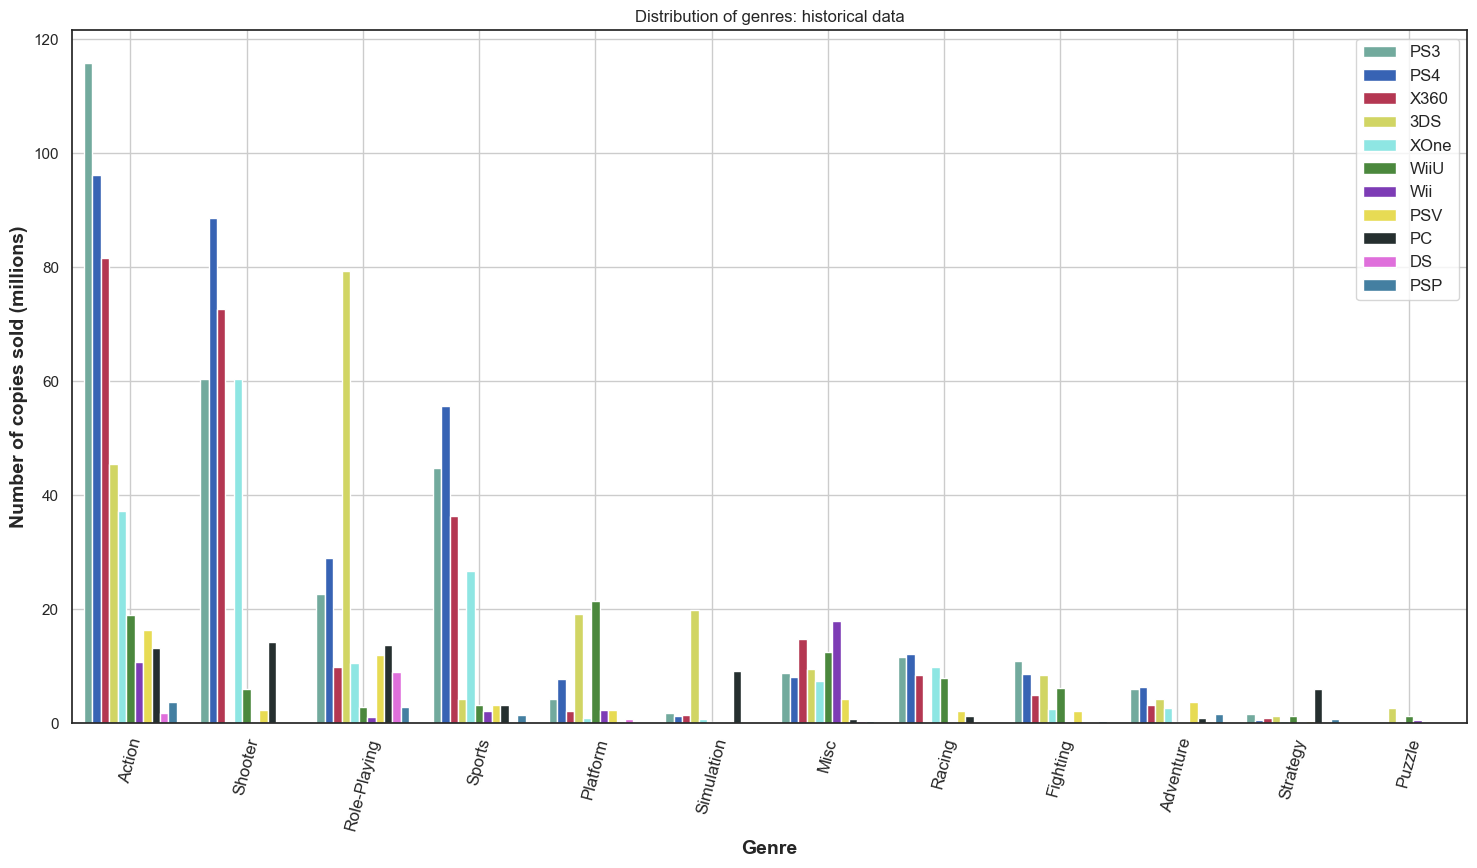

In [84]:
colors = ["#69b3a2", "#225dc9", '#c92246', '#e3e851', '#7ff5f1', '#439431', '#7e28c9', '#ffef3b', '#243030', '#f25ced', '#3583b0']
sns.set_palette(sns.color_palette(colors))

sns.barplot(data=platform_genres, x='genre', y='total_sales', hue='platform')
#sns.set(font_scale=1.2)
sns.set_theme(rc={'figure.figsize':(20, 10)}, style='white')
plt.title('Distribution of genres: historical data', fontsize=12)
plt.xlabel('Genre', fontsize=14, fontweight='bold', labelpad=6)
plt.ylabel('Number of copies sold (millions)', fontsize=14, fontweight='bold')
plt.legend(fontsize='medium', loc='upper right')
plt.xticks(size=12, rotation=75)
plt.grid(True)
plt.show()

The chart revealed an interesting feature of the 3DS console: neither sports games nor shooters are popular here, while role-playing games, on the other hand, lead in popularity. Additionally, among XOne users, shooters are significantly more popular than action games, and sports games are more popular than role-playing games. Such features should definitely be taken into account when forecasting expected game profits.

**Summary**  
We have determined that the most popular genres are action, shooter, and role-playing games. However, if we want to forecast sales for a specific platform, we should focus not on the general sales dynamics but on the specifics of the particular model. It is possible that the technical characteristics or the design of the consoles influence the popularity of certain games.

## 4. User profile
In this section, we will create a rough profile of the user in each region (NA, EU, JP, OTHER). The metrics we will examine include:

* Top 5 platforms in each region
* Genres popular in each region
* The impact of the ESRB rating on sales in each region
### 4.1 Popular consoles
We will use the data slice for 2012-2016 that we prepared earlier.

In [85]:
fresh_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1.0,-1.0,unknown,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,unknown,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,-1.0,-1.0,unknown,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1.0,-1.0,unknown,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,unknown,0.01


2885 observations, which is quite sufficient for a comparative analysis by region. Now, let's create a pivot table displaying the total sales for each platform in each individual region.

In [86]:
fresh_data_region = (fresh_data.pivot_table(index='platform',
                                            values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'],
                                            aggfunc='sum'                                           
                                           )
                     .reset_index()
                     .melt(id_vars=['platform'])
                     .sort_values('value', ascending=False)
                    )

fresh_data_region.head(10)

,platform,variable,value
4,PS4,eu_sales,141.09
31,X360,na_sales,140.05
26,PS4,na_sales,108.74
3,PS3,eu_sales,106.86
25,PS3,na_sales,103.38
32,XOne,na_sales,93.12
11,3DS,jp_sales,87.79
9,X360,eu_sales,74.52
22,3DS,na_sales,55.31
10,XOne,eu_sales,51.59


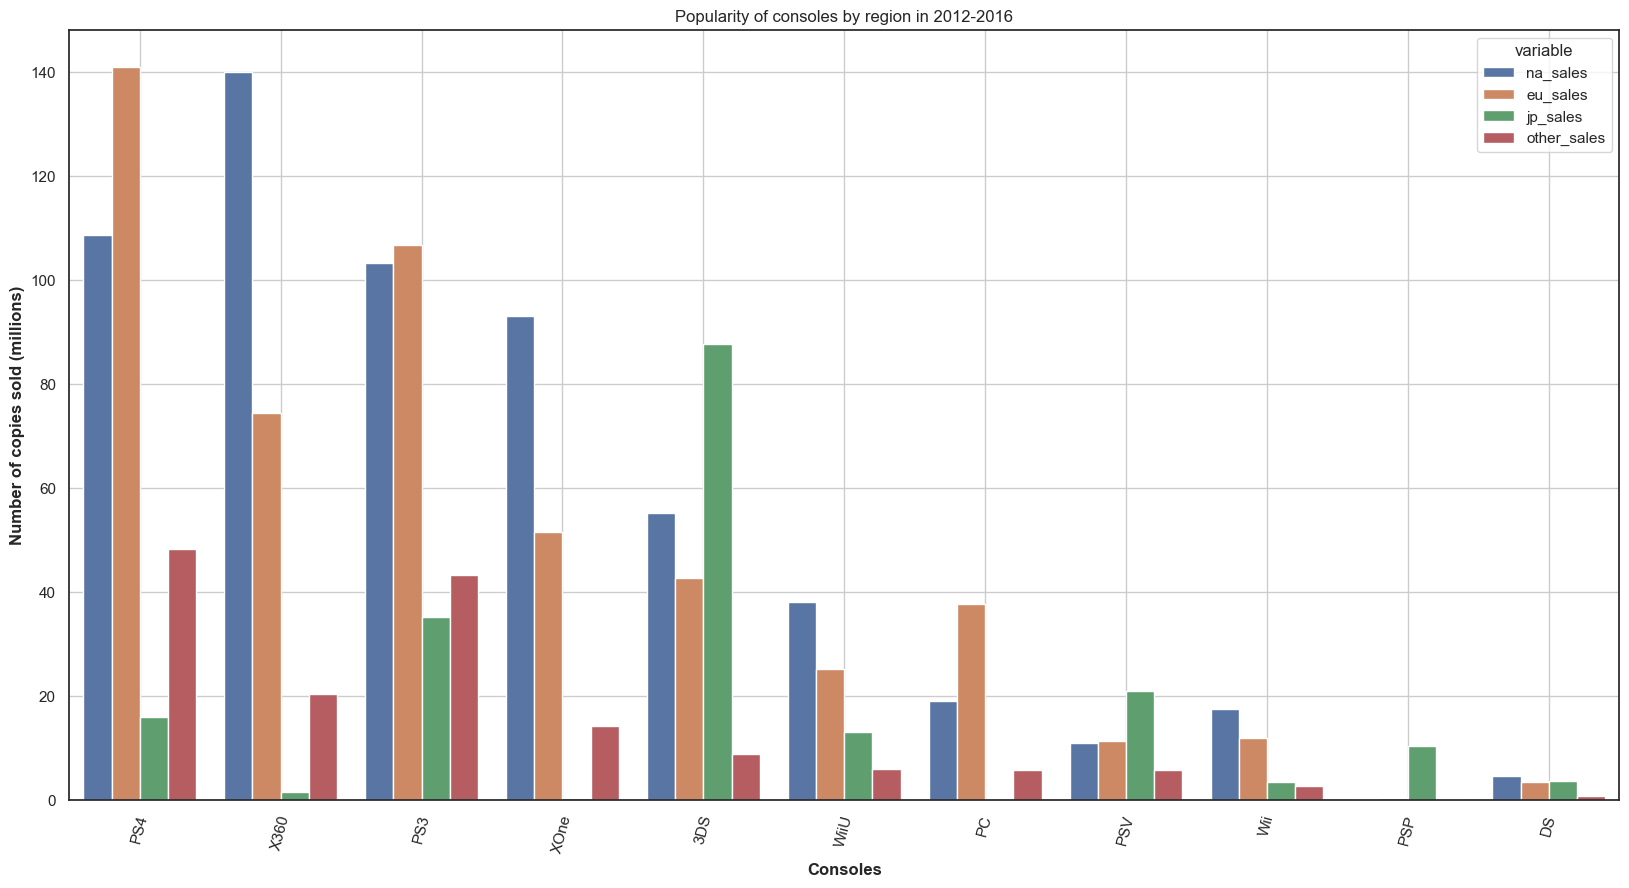

In [87]:
ax = sns.barplot(x=fresh_data_region.platform,
                 y=fresh_data_region.value,
                 hue=fresh_data_region.variable,
                 hue_order=['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
                 )
sns.set_theme(rc={'figure.figsize':(12, 8)}, style='white')
plt.title('Popularity of consoles by region in 2012-2016')
plt.xlabel('Consoles', fontsize=12, fontweight='bold', labelpad=6)
plt.ylabel('Number of copies sold (millions)', fontsize=12, fontweight='bold')
plt.xticks(rotation=75)
plt.grid(True)
plt.show()

The popularity of platforms varies across different regions:

* na_sales: X360, PS4, PS, XOne, 3DS
* eu_sales: PS4, PS3, X360, XOne, 3DS
* jp_sales: 3DS, PS3, PSV, PS4, WiiU
* other: PS4, PS3, X360, XOne, 3DS

The most unusual platform distribution is in the Japanese market: the X360 and XOne platforms are almost not popular there. On the other hand, platforms like 3DS, PSV, and PSP are still in demand and show higher sales than in other regions.

### 4.2 Popular genres
Now let's examine how the popularity of game genres varies from region to region. We will create a separate auxiliary dataset based on the data slice for games released in 2012-2016.

In [88]:
fresh_data_genre = (fresh_data.pivot_table(index='genre',
                                            values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'],
                                            aggfunc='sum'                                           
                                           )
                     .reset_index()
                     .melt(id_vars=['genre'])
                     .sort_values('value', ascending=False)
                    )

fresh_data_genre.head(10)

,genre,variable,value
24,Action,na_sales,177.84
0,Action,eu_sales,159.34
32,Shooter,na_sales,144.77
8,Shooter,eu_sales,113.47
34,Sports,na_sales,81.53
10,Sports,eu_sales,69.09
19,Role-Playing,jp_sales,65.44
31,Role-Playing,na_sales,64.00
12,Action,jp_sales,52.80
36,Action,other_sales,51.14


Let's visualize the obtained genre distribution by region using pie charts. But first, we'll perform an additional categorization of genres: we'll keep the top 5 genres, and the rest will be labeled as "Other" and recorded in a new column using a special function.  
Before categorizing, let's record the number of games for each genre in the dataset.

In [89]:
fresh_data['genre'].value_counts()

genre
Action          1031
Role-Playing     370
Adventure        302
Sports           267
Shooter          235
Misc             192
Racing           115
Fighting         109
Platform          85
Simulation        80
Strategy          71
Puzzle            28
Name: count, dtype: int64

In [92]:
popular_genres = ['Action', 'Role-Playing', 'Adventure', 'Shooter', 'Sports']

def genre_grouped(row):
    genre = row['genre']
    if genre in popular_genres:
        return genre
    else:
        return 'Other'

fresh_data.loc[:, 'genre_group'] = fresh_data.apply(genre_grouped, axis=1)
fresh_data['genre_group'].value_counts()

genre_group
Action          1031
Other            680
Role-Playing     370
Adventure        302
Sports           267
Shooter          235
Name: count, dtype: int64

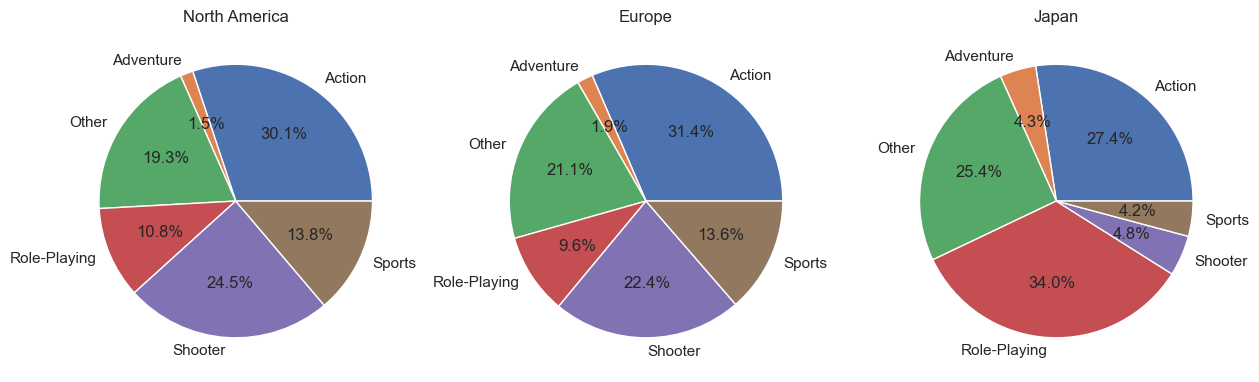

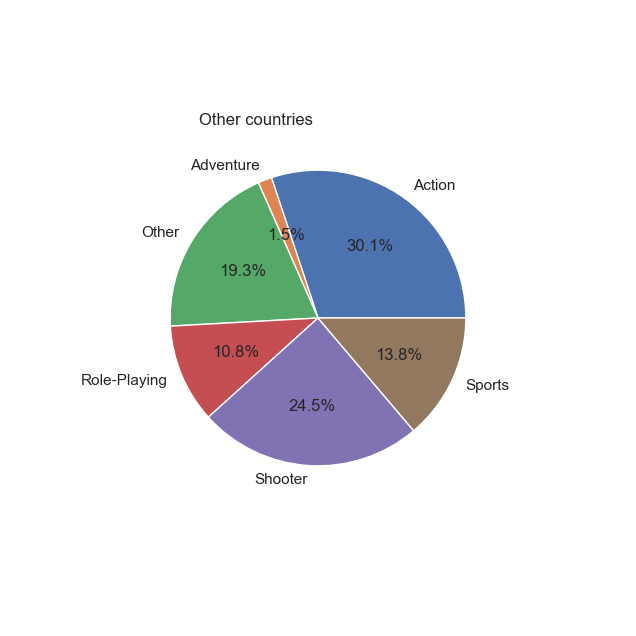

In [93]:
subset = fresh_data.pivot_table(index='genre_group', 
                          values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], 
                          aggfunc='sum').reset_index()

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,15))

labels = subset['genre_group']
values = subset['na_sales']
ax1.pie(values, labels=labels, autopct = '%1.1f%%')
ax1.set_title('North America')

labels = subset['genre_group']
values = subset['eu_sales']
ax2.pie(values, labels=labels, autopct = '%1.1f%%')
ax2.set_title('Europe')

labels = subset['genre_group']
values = subset['jp_sales']
ax3.pie(values, labels=labels, autopct = '%1.1f%%')
ax3.set_title('Japan')
plt.show()

labels = subset['genre_group']
values = subset['na_sales']
plt.pie(values, labels=labels, radius=0.6, autopct = '%1.1f%%')
plt.title('Other countries', x=0.4, y=0.8)
plt.show() 

The leading genre in all regions except Japan is action, followed by shooters and sports games. Japanese users much more frequently choose role-playing games.

### 4.3 Impact of rating
First, let's take a look at the rating values present in the dataset and how to interpret them.

In [94]:
data['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

* `E` — everyone, meaning suitable for all age groups.
* `K-A` — kids to adults, an old rating for E that existed before 1998.
* `EC` — early childhood, games safe for children aged 3 and older.
* `E10+` — everyone 10 and older, for those aged 10 and up.
* `T` — teen, games for teenagers aged 13 and older.
* `M` — mature, games for those aged 17 and older.
* `AO` — adults only, for adults aged 18 and older.
* `RP` — rating pending, the game is awaiting an ESRB age rating.
* `unknown` — games without a genre rating.

When analyzing sales by rating, it should be noted that sales of games with the `E` and `K-A` ratings can be summed up.

It is also reasonable to assume that games for children (the youngest age categories `EC` and `E10+`) will likely have more modest sales due to lower demand from buyers.

The `RP` rating in this study can be combined with the unknown rating. Let's check how many games with this label are present in the original dataset:

In [95]:
data.query('rating == "RP"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14270,Supreme Ruler: Cold War,PC,2011,Strategy,0.0,0.03,0.0,0.01,63.0,6.8,RP,0.04


There is only one game, for the `PC` platform, which we will not consider in this study. We will not remove this entry from the dataset.

Before moving on to the analysis, it should be noted that the ESRB rating system is recognized, implemented, and used in Canada, Mexico, and the USA. Therefore, in other regions (EU, JP, OTHER), this rating system may not influence the buyer's choice: people may be unfamiliar with the labeling and simply not pay attention to it.

Let's check our assumption using a pivot table and a chart.

In [96]:
fresh_data_rating = (fresh_data.pivot_table(index='rating',
                                            values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'],
                                            aggfunc='sum'                                           
                                           )
                     .reset_index()
                     .melt(id_vars=['rating'])
                     .sort_values('value', ascending=False)
                    )

fresh_data_rating

,rating,variable,value
12,M,na_sales,231.57
2,M,eu_sales,193.96
10,E,na_sales,114.37
0,E,eu_sales,113.03
9,unknown,jp_sales,108.84
14,unknown,na_sales,103.31
4,unknown,eu_sales,91.50
11,E10+,na_sales,75.70
13,T,na_sales,66.02
17,M,other_sales,63.38


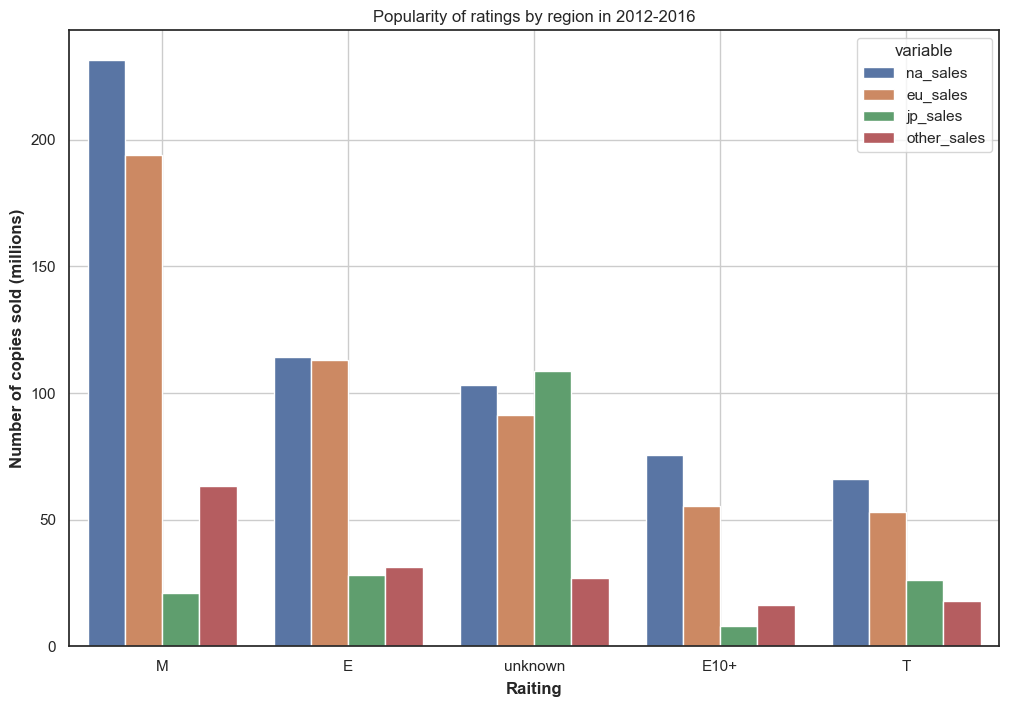

In [97]:
ax = sns.barplot(x=fresh_data_rating.rating,
                 y=fresh_data_rating.value,
                 hue=fresh_data_rating.variable,
                 hue_order=['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
                 )
sns.set_theme(rc={'figure.figsize': (12, 8)}, style='white')
plt.title('Popularity of ratings by region in 2012-2016')
plt.xlabel('Raiting', fontsize=12, fontweight='bold', labelpad=6)
plt.ylabel('Number of copies sold (millions)', fontsize=12, fontweight='bold')
plt.grid(True)
plt.show()

The chart shows that in Europe and North America, there is a common pattern: the most popular games are those rated `M` (for 17 and older), followed by games for everyone (`E`), then games for kids aged 10 and older, and finally, games for kids aged 13 and older.

Sales in other regions show a similar trend, with the difference being that the `T` category is more popular than `E10+` here. However, the total sales in each category, as well as the gap between them, do not suggest a clear trend.

In Japan, the most popular games are rated `M`, with all other ratings having roughly the same weight. However, it should be noted that the ESRB rating may not be recognized by buyers, as Japan uses its own rating system, CERO, which has a different approach to categorization.

We will exclude games with an undefined rating from the analysis, as it's unclear whether the game has no rating at all or if it has a rating but according to different standards.

Additionally, we note that games for babies (`EC`), as well as games for adults aged 18+ (`AO`), are not represented among the games sold between 2012-2016. Both of these age categories have their own consumers. It can be assumed that games with these ratings have migrated to other platforms.

**Summary**  
We have analyzed games based on several characteristics relative to their regional affiliation to create general user profiles.

* `North America`  
   A user from this region is most likely playing on an Xbox 360 or PS4 console. The `PS3` platform remains popular but may soon be overtaken by `Xbox One`. Action games and shooters are in high demand, and the expected age rating for games is M and E.

* `Europe`  
   A European buyer is most likely a user of the `PS4`, with the previous generation `PS3` still quite popular. Popular American platforms like `Xbox One` and `Xbox 360` generate significantly less interest. European users prefer action games and shooters, and the expected age rating for games is M and E.

* `Japan`  
   A user from Japan is most likely to prefer games for the `3DS` platform. Unlike other regions, role-playing games are in higher demand here, followed by action games. It wasn't possible to determine the preferred rating since Japan uses a different age categorization system for games.

* `Other regions`  
   Overall, users in other parts of the world tend to show similar preferences as European users: the `PS4` platform is popular, and the `PS3` still holds its position. Genre preferences are focused on action games and shooters. It is most likely that users in other regions prefer M rated games. Other age categories are equally popular.
   
## 5. Hypothesis Testing
In this part of the study, we will test two hypotheses proposed by the business:
1. The average user ratings of the Xbox One and PC platforms are the same.
2. The average user ratings of the Action and Sports genres are different.
Both hypotheses will be tested at a significance level of alpha = 0.05.

### 5.1 Hypothesis #1: Ratings of `Xbox One` and `PC` Platforms
We define our null and alternative hypotheses as follows:

* $H_0$: The average user ratings of the Xbox One and PC platforms are the same.
* $H_1$: The average user ratings of the Xbox One and PC platforms are different.

Since the business is interested in whether the ratings are equal, we will test the hypothesis using a two-tailed t-test.

To conduct the analysis, we will prepare two samples: games on the Xbox One and PC platforms. In both cases, we will select only those observations where the user rating is different from -1.

In [100]:
xone_scores = data.query('platform == "XOne" and user_score > -1 and year_of_release >= 2012')
pc_scores = data.query('platform == "PC" and user_score > -1 and year_of_release >= 2012')

# to determine whether the samples are equal and correctly set the equal_var attribute, 
# we'll compare the descriptive statistics of both samples:

print(f"User Rating Statistics for XOne:\n{xone_scores['user_score'].describe()} \n"
      f"~~~~~~~ \n"
      f"User Rating Statistics for РС:\n{pc_scores['user_score'].describe()}"
     )

User Rating Statistics for XOne:
count    182.000000
mean       6.521429
std        1.380941
min        1.600000
25%        5.800000
50%        6.800000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64 
~~~~~~~ 
User Rating Statistics for РС:
count    206.000000
mean       6.428641
std        1.664465
min        1.400000
25%        5.500000
50%        6.800000
75%        7.700000
max        9.300000
Name: user_score, dtype: float64


The sample size and distribution allow us to use the t-test. For this hypothesis, we will conduct a two-tailed test for two independent samples.

The sample sizes, as well as the standard deviations, differ slightly. For greater accuracy, we will set `equal_var=False`.

In [101]:
alpha = 0.05

results = st.ttest_ind(xone_scores['user_score'],
                       pc_scores['user_score'],
                       equal_var=False,
                       alternative='two-sided'
                      )

print(results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

0.5489537965134912
Failed to reject the null hypothesis


We do not reject the null hypothesis, as we have grounds to believe that the platform ratings are equal at the given significance level of 0.05.

### 5.2 Hypothesis #2: Ratings of Action and Sports Genres
We define our null and alternative hypotheses as follows:

* $H_0$: The average user ratings of the Action and Sports genres are the same.
* $H_1$: The average user ratings of the Action and Sports genres are different.
Since the business is interested in whether the ratings differ, we will use a two-tailed t-test, just like in the first case.

For the analysis, we will extract two samples from the 2012–2016 period:
* Games in the Action genre
* Games in the Sports genre

In [102]:
action_scores = data.query("genre == 'Action' and year_of_release >= 2012 and user_score > -1")
sports_scores = data.query("genre == 'Sports' and year_of_release >= 2012 and user_score > -1")

# to determine whether the samples are equal and correctly set the equal_var attribute, 
# we'll compare the descriptive statistics of both samples:

print(f"User Rating Statistics for the Action Genre: \n{action_scores['user_score'].describe()} \n"
      f"~~~~~~~ \n"
      f"User Rating Statistics for the Sports Genre: \n{sports_scores['user_score'].describe()}"
     )

User Rating Statistics for the Action Genre: 
count    523.000000
mean       6.825048
std        1.374440
min        1.600000
25%        6.250000
50%        7.100000
75%        7.800000
max        9.100000
Name: user_score, dtype: float64 
~~~~~~~ 
User Rating Statistics for the Sports Genre: 
count    194.000000
mean       5.455670
std        1.743142
min        0.200000
25%        4.300000
50%        5.750000
75%        6.800000
max        8.800000
Name: user_score, dtype: float64


The sample size and distribution allow us to use the t-test. For this hypothesis, we will conduct a two-tailed test for two independent samples.

The samples differ significantly in size, and their standard deviation values also vary. For greater accuracy, we will set `equal_var=False`.

In [103]:
alpha = 0.05

results = st.ttest_ind(action_scores['user_score'],
                       sports_scores['user_score'],
                       equal_var=False,
                       alternative='two-sided'
                      )

print(results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

5.989458066467418e-20
Reject the null hypothesis


We reject the null hypothesis and conclude that, at a significance level of 0.05, the user ratings for the Action and Sports genres are not equal.

**Summary** 
During the analysis of user ratings, we established that the sample means follow a normal distribution and that the sample sizes significantly exceed the minimum requirements. Based on this, we concluded that user ratings in our dataset are normally distributed, allowing us to use the t-test for hypothesis testing.

Since the business was interested in whether the means were equal or not, we chose a two-tailed test in both cases. We also determined that users of different platforms form two independent samples (for comparison: dependent samples would be users of PS3 and PS4, as some players migrate from an older console to a new one by the same manufacturer). We made a similar decision for the two different genres.

At the final stage of the study, we tested two hypotheses regarding the average user ratings of games across different genres and platforms. With high confidence, we conclude that:
* The average user ratings for `Xbox One` and `PC` games are equal.
* The average user ratings for `Action` and `Sports` games are not equal.

This information can be useful when selecting products for promotion and planning marketing campaigns.

## 6. Conclusions
During data processing, we performed data cleaning by removing duplicates and handling missing values:

* For key observation characteristics (game title and release year), we decided to remove rows with missing data, as this was necessary for further statistical analysis and feasible due to the low proportion of such cases.
* For critical features with a high percentage of missing values (ratings, critic, and user scores), we retained the rows but did not replace missing values with the most frequent indicators within a typical group. Instead, we filled in the gaps with standard placeholder values distinguishable from real data. For ratings, we used the label "unknown"; for critic and user scores, we used `-1`.

After cleaning the data, we calculated the total sales for each observation and added this information to the main dataset.
Key Insights for Business:

* The sharp decline in game releases stabilized by 2012. The period from 2012 to 2016 is well-suited for market research and sales forecasting.
* By analyzing platform profitability dynamics, we determined that the approximate lifespan of a gaming platform on the market is `seven years`. This insight can help colleagues predict platform profitability over the next 2–3 years. The most profitable consoles are those launched 2–3 years before the analysis was conducted, as this is roughly how long it takes for a gaming platform to reach peak sales.
* Based on previous analysis, we identified the top five most popular platforms: 3DS, PS3, PS4, X360, and XOne.
* We found a weak correlation between sales volume and critic ratings, suggesting that while this factor can be considered in business planning, it should not be the main pillar of a marketing strategy. Regarding user ratings, we found no correlation with sales either within the key group or across all platforms with games released between 2012 and 2016.
* We analyzed sales distribution by genre and platform, revealing that the popularity of the same genre varies depending on the platform. For example, on PS3, the best-selling games are in the Action genre, while on the newer PS4, shooters are more popular. This means that when selecting games for promotion, the platform must always be considered.

We created user profiles based on regional preferences:
* `North America:` Popular consoles are Xbox 360 and PS4. PS3 remains in demand, but Xbox One may soon overtake it. The most popular genres are Action and Shooters, with expected age ratings M (17+) and E (Everyone).
* `Europe:` The PS4 is the dominant platform, with PS3 still widely used. European players favor Action and Shooter games, with expected age ratings M and E.
* `Japan:` The 3DS is the most popular platform. Unlike other regions, RPGs are the most in-demand genre, followed by Action games. Preferred age ratings could not be determined due to Japan using a different game rating system.
* `Other regions:` Preferences generally align with those in Europe: PS4 is the most popular platform, with PS3 still retaining users. The most popular genres are Action and Shooter games, and the most likely preferred rating is M. Preferences for other age ratings are not strongly expressed.

For a more comprehensive user profile, it would be beneficial to gather information on the distribution of players by gender, age, and socioeconomic status, as this data would significantly improve forecasting accuracy.

**Business Recommendations** 
We tested the hypotheses provided by the business and reached the following conclusions:
* The average user ratings for Xbox One and PC games are equal.
* The average user ratings for Action and Sports games are not equal.

Earlier in our study, we found that there is no strong correlation between user ratings and the number of games sold. However, we hypothesize that user ratings are influenced by critic scores, often with a slight upward bias. Thus, when considering other key factors (platform lifecycle, genre popularity trends), user ratings can be factored into product promotion planning.

**Which games should be promoted next season with a limited advertising budget?**  
* Selecting a game for both North America and Europe:
    * Genre: Action (if a highly anticipated release is expected) or Shooter (as the most reliable genre).
    * Console: PS4 (popular in both regions).
    * Age Rating: 17+ (to maximize audience reach).
* Selecting a game for North America:
    * Genre: Action (if a highly anticipated release is expected) or Shooter.
    * Console: Xbox One.
    * Age Rating: 17+.

If a highly anticipated RPG release is announced and the marketing budget allows for an additional campaign:
* Selecting a game for Japan:
    * Genre: RPG.
    * Console: 3DS.
    * Age Rating: 17+.